**Author:** Satrajit Ghosh
**Course:** Machine Vision  
**Date:** November 2025

In [1]:
# checking for gpu
import sys
import os
import warnings
warnings.filterwarnings('ignore')

!nvidia-smi

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n{'-'*40}")
print(f"Running on: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"{'-'*40}")

Wed Nov 26 00:57:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
# installing requirements
# using %pip so colab handles the kernel restart if needed

# core ml stuff
# %pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# image utils
%pip install -q opencv-python numpy scipy matplotlib scikit-image pillow
%pip install -q lpips kornia einops tqdm pandas seaborn

# depth estimation model
%pip install -q timm

# stylegan needs these
%pip install -q ninja gdown

# for plotting
%pip install -q plotly kaleido

print("Dependencies installed.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.5 MB/s eta 0:00:00
✓ All dependencies installed!


In [3]:
# cloning the necessary repos
import os

# StyleGAN2-ADA
if not os.path.exists('./stylegan2-ada-pytorch'):
    !git clone -q https://github.com/NVlabs/stylegan2-ada-pytorch.git
    print("StyleGAN2-ADA cloned.")

# StyLitGAN
if not os.path.exists('./stylitgan'):
    !git clone -q https://github.com/anandbhattad/stylitgan.git
    print("StyLitGAN cloned.")

# MiDaS (depth)
if not os.path.exists('./MiDaS'):
    !git clone -q https://github.com/isl-org/MiDaS.git
    print("MiDaS cloned.")

sys.path.insert(0, './stylegan2-ada-pytorch')
sys.path.insert(0, './stylitgan')
sys.path.insert(0, './MiDaS')

print("Repos ready.")

✓ StyleGAN2-ADA cloned
✓ StyLitGAN cloned
✓ MiDaS cloned

✓ All repositories ready!


In [4]:
# standard imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from PIL import Image
import cv2
from tqdm.auto import tqdm
from typing import Tuple, Optional, List, Dict, Union
import pickle
import copy
import math
from collections import defaultdict
from einops import rearrange, repeat
import kornia
import kornia.filters as KF

# metrics
import lpips
from torchvision import transforms, models
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# stylegan imports
import dnnlib
import legacy

# keeping it reproducible
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(42)
print("Imports done.")

✓ All imports successful!


In [5]:
# wrapper for stylegan2 to make it easier to use
class StyleGAN2Generator:
    def __init__(self, model_path: str, device: str = 'cuda'):
        self.device = device
        print(f"Loading StyleGAN2 from {model_path}...")

        with open(model_path, 'rb') as f:
            data = pickle.load(f)

        # handling different pickle formats
        if type(data).__name__ == '_TFNetworkStub':
            self.G = legacy.convert_tf_generator(data).to(device)
        elif isinstance(data, dict):
            self.G = data.get('G_ema', data.get('G')).to(device)
        else:
            self.G = data.to(device)

        self.G.eval()

        # saving model info
        self.img_resolution = self.G.img_resolution
        self.img_channels = self.G.img_channels
        self.w_dim = self.G.w_dim
        self.z_dim = self.G.z_dim
        self.num_ws = self.G.num_ws

        # precomputing mean latent for truncation trick
        self._compute_mean_latent()

        print(f"Model loaded: {self.img_resolution}x{self.img_resolution}")

    def _compute_mean_latent(self, n_samples: int = 10000):
        with torch.no_grad():
            z = torch.randn(n_samples, self.z_dim, device=self.device)
            w = self.G.mapping(z, None)
            self.w_mean = w.mean(dim=0, keepdim=True)

    @torch.no_grad()
    def generate_z(self, n: int, seed: Optional[int] = None) -> torch.Tensor:
        if seed is not None:
            torch.manual_seed(seed)
        return torch.randn(n, self.z_dim, device=self.device)

    @torch.no_grad()
    def z_to_w(self, z: torch.Tensor, truncation_psi: float = 0.7) -> torch.Tensor:
        w = self.G.mapping(z, None)
        if truncation_psi < 1.0:
            w = self.w_mean + truncation_psi * (w - self.w_mean)
        return w

    def synthesize(self, w: torch.Tensor, noise_mode: str = 'const') -> torch.Tensor:
        # no torch.no_grad() here so we can backprop if needed
        return self.G.synthesis(w, noise_mode=noise_mode)

    @torch.no_grad()
    def generate(self, n: int, seed: Optional[int] = None,
                 truncation_psi: float = 0.7) -> Tuple[torch.Tensor, torch.Tensor]:
        z = self.generate_z(n, seed)
        w = self.z_to_w(z, truncation_psi)
        img = self.synthesize(w)
        return img, w

# getting the model
MODEL_PATH = './stylitgan/stylitgan_bedroom.pkl'

if not os.path.exists(MODEL_PATH):
    print(f"Model missing at {MODEL_PATH}")
    print("Downloading it now...")
    import gdown
    os.makedirs('./stylitgan', exist_ok=True)
    try:
        gdown.download(
            'https://drive.google.com/uc?id=1YzZemZAp7BVW701_BZ7uabJWJnsrac-_',
            MODEL_PATH, quiet=False
        )
    except Exception as e:
        print(f"Download failed: {e}")
        print("You might need to manually upload stylitgan_bedroom.pkl")
        raise FileNotFoundError(f"Model file not found: {MODEL_PATH}")

generator = StyleGAN2Generator(MODEL_PATH, device)

# quick test
with torch.no_grad():
    test_imgs, test_ws = generator.generate(4, seed=42)
print(f"Test generation shape: {test_imgs.shape}")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

Loading StyleGAN2 from ./stylitgan/stylitgan_bedroom.pkl...
✓ Model loaded: 256x256
  W-space dim: 512, Layers: 14

Test generation: torch.Size([4, 3, 256, 256])


In [6]:
# estimating depth and normals with MiDaS
class NeuralGeometryEstimator(nn.Module):
    def __init__(self, model_type: str = 'DPT_Large', device: str = 'cuda'):
        super().__init__()
        self.device = device
        self.model_type = model_type

        print(f"Loading MiDaS {model_type}...")

        self.midas = torch.hub.load('intel-isl/MiDaS', model_type, trust_repo=True)
        self.midas.to(device).eval()

        midas_transforms = torch.hub.load('intel-isl/MiDaS', 'transforms', trust_repo=True)
        if model_type in ['DPT_Large', 'DPT_Hybrid']:
            self.transform = midas_transforms.dpt_transform
        else:
            self.transform = midas_transforms.small_transform

        # sobel kernels for computing normals from depth
        self.register_buffer('sobel_x', torch.tensor(
            [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32, device=self.device
        ).view(1, 1, 3, 3) / 8.0)
        self.register_buffer('sobel_y', torch.tensor(
            [[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32, device=self.device
        ).view(1, 1, 3, 3) / 8.0)

        print("MiDaS loaded.")

    def estimate_depth(self, images: torch.Tensor) -> torch.Tensor:
        B, C, H, W = images.shape
        imgs_01 = (images + 1) / 2

        depths = []
        for i in range(B):
            img_np = (imgs_01[i].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
            input_batch = self.transform(img_np).to(self.device)

            with torch.no_grad():
                depth = self.midas(input_batch)
                depth = F.interpolate(depth.unsqueeze(1), size=(H, W),
                                     mode='bilinear', align_corners=False)
            depths.append(depth)

        depth = torch.cat(depths, dim=0)
        # normalize to 0-1
        depth = (depth - depth.min()) / (depth.max() - depth.min() + 1e-8)
        return depth

    def depth_to_normals(self, depth: torch.Tensor,
                         focal_length: float = 256.0) -> torch.Tensor:
        B, _, H, W = depth.shape

        # finite differences
        dz_dx = F.conv2d(depth, self.sobel_x.expand(1, 1, 3, 3), padding=1)
        dz_dy = F.conv2d(depth, self.sobel_y.expand(1, 1, 3, 3), padding=1)

        normals = torch.cat([
            -dz_dx * focal_length,
            -dz_dy * focal_length,
            torch.ones_like(dz_dx)
        ], dim=1)

        normals = F.normalize(normals, dim=1, eps=1e-8)
        return normals

    def forward(self, images: torch.Tensor) -> Dict[str, torch.Tensor]:
        depth = self.estimate_depth(images)
        normals = self.depth_to_normals(depth)
        return {'depth': depth, 'normals': normals}

geo_estimator = NeuralGeometryEstimator('DPT_Large', device)

# testing it out
print("\nTesting geometry...")
with torch.no_grad():
    geo_results = geo_estimator(test_imgs[:1])
print(f"Depth shape: {geo_results['depth'].shape}")
print(f"Normals shape: {geo_results['normals'].shape}")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

Wed Nov 26 00:58:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             53W /  400W |     637MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

100%|██████████| 1.28G/1.28G [00:11<00:00, 124MB/s]
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


✓ MiDaS loaded successfully

Testing geometry estimation...
Depth shape: torch.Size([1, 1, 256, 256])
Normals shape: torch.Size([1, 3, 256, 256])

✓ GPU Memory after loading: 1.50 GB used


In [7]:
# spherical harmonics for lighting
class SphericalHarmonics:
    # SH constants
    SH_C0 = 0.28209479177387814
    SH_C1 = 0.4886025119029199
    SH_C2 = [1.0925484305920792, 0.31539156525252005, 0.5462742152960396]

    @staticmethod
    def eval_sh_basis(normals: torch.Tensor, order: int = 2) -> torch.Tensor:
        x = normals[:, 0:1]
        y = normals[:, 1:2]
        z = normals[:, 2:3]

        basis = [torch.ones_like(x) * SphericalHarmonics.SH_C0]

        if order >= 1:
            basis.extend([
                SphericalHarmonics.SH_C1 * y,
                SphericalHarmonics.SH_C1 * z,
                SphericalHarmonics.SH_C1 * x
            ])

        if order >= 2:
            basis.extend([
                SphericalHarmonics.SH_C2[0] * x * y,
                SphericalHarmonics.SH_C2[0] * y * z,
                SphericalHarmonics.SH_C2[1] * (3 * z * z - 1),
                SphericalHarmonics.SH_C2[0] * x * z,
                SphericalHarmonics.SH_C2[2] * (x * x - y * y)
            ])

        return torch.cat(basis, dim=1)

    @staticmethod
    def render_diffuse(normals: torch.Tensor,
                       sh_coeffs: torch.Tensor) -> torch.Tensor:
        B, _, H, W = normals.shape
        if sh_coeffs.dim() == 2:
            sh_coeffs = sh_coeffs.unsqueeze(0).expand(B, -1, -1)

        sh_basis = SphericalHarmonics.eval_sh_basis(normals, order=2)
        shading = torch.zeros(B, 3, H, W, device=normals.device)

        for c in range(3):
            for i in range(9):
                shading[:, c:c+1] += sh_coeffs[:, i:i+1, c:c+1].unsqueeze(-1) * sh_basis[:, i:i+1]

        return torch.clamp(shading, 0, 1)

    @staticmethod
    def random_sh_lighting(batch_size: int = 1,
                           device: str = 'cuda',
                           intensity_range: Tuple[float, float] = (0.3, 1.0)
                          ) -> torch.Tensor:
        sh_coeffs = torch.zeros(batch_size, 9, 3, device=device)

        # ambient
        ambient = torch.rand(batch_size, 1, 3, device=device) * 0.3 + 0.2
        sh_coeffs[:, 0:1, :] = ambient

        # directional
        direction = F.normalize(torch.randn(batch_size, 3, device=device), dim=1)
        intensity = torch.rand(batch_size, 1, device=device) * \
                    (intensity_range[1] - intensity_range[0]) + intensity_range[0]

        color_temp = torch.rand(batch_size, 1, device=device) * 2 - 1
        color = torch.ones(batch_size, 3, device=device)
        color[:, 0] += color_temp.squeeze() * 0.2
        color[:, 2] -= color_temp.squeeze() * 0.2
        color = color * intensity

        sh_coeffs[:, 1, :] = direction[:, 1:2] * color
        sh_coeffs[:, 2, :] = direction[:, 2:3] * color
        sh_coeffs[:, 3, :] = direction[:, 0:1] * color

        # small random variations for higher bands
        sh_coeffs[:, 4:, :] = torch.randn(batch_size, 5, 3, device=device) * 0.1

        return sh_coeffs

print("Spherical Harmonics helper defined.")

# quick test
test_sh = SphericalHarmonics.random_sh_lighting(1, device)
test_normals = geo_estimator(test_imgs[:1])['normals']
sh_shading = SphericalHarmonics.render_diffuse(test_normals, test_sh)
print(f"SH shading shape: {sh_shading.shape}")

✓ Spherical Harmonics module ready
SH shading shape: torch.Size([1, 3, 256, 256])


In [8]:
# brdf implementation for rendering
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdvancedBRDF(nn.Module):
    def __init__(self):
        super().__init__()
        self.eps = 1e-7

    def fresnel_schlick(self, cos_theta: torch.Tensor,
                        f0: torch.Tensor) -> torch.Tensor:
        return f0 + (1.0 - f0) * torch.pow(1.0 - cos_theta.clamp(0, 1), 5.0)

    def distribution_ggx(self, n_dot_h: torch.Tensor,
                         roughness: torch.Tensor) -> torch.Tensor:
        a = roughness * roughness
        a2 = a * a
        n_dot_h2 = n_dot_h * n_dot_h

        denom = n_dot_h2 * (a2 - 1.0) + 1.0
        denom = math.pi * denom * denom

        return a2 / (denom + self.eps)

    def geometry_smith(self, n_dot_v: torch.Tensor, n_dot_l: torch.Tensor,
                       roughness: torch.Tensor) -> torch.Tensor:
        r = roughness + 1.0
        k = (r * r) / 8.0

        g1_v = n_dot_v / (n_dot_v * (1.0 - k) + k + self.eps)
        g1_l = n_dot_l / (n_dot_l * (1.0 - k) + k + self.eps)

        return g1_v * g1_l

    def cook_torrance(self, normals: torch.Tensor, light_dir: torch.Tensor,
                      view_dir: torch.Tensor, albedo: torch.Tensor,
                      roughness: float = 0.5, metallic: float = 0.0
                     ) -> torch.Tensor:
        albedo = albedo.to(dtype=torch.float32)

        if light_dir.dim() == 1:
            light_dir = light_dir.view(1, 3, 1, 1)
        if view_dir.dim() == 1:
            view_dir = view_dir.view(1, 3, 1, 1)

        h = F.normalize(light_dir + view_dir, dim=1)

        n_dot_l = (normals * light_dir).sum(dim=1, keepdim=True).clamp(0, 1)
        n_dot_v = (normals * view_dir).sum(dim=1, keepdim=True).clamp(0, 1)
        n_dot_h = (normals * h).sum(dim=1, keepdim=True).clamp(0, 1)
        v_dot_h = (view_dir * h).sum(dim=1, keepdim=True).clamp(0, 1)

        if not torch.is_tensor(roughness):
            roughness = torch.full_like(n_dot_l, float(roughness),
                                        dtype=albedo.dtype, device=albedo.device)
        else:
            roughness = roughness.to(device=albedo.device, dtype=albedo.dtype)

        if not torch.is_tensor(metallic):
            metallic = torch.full_like(n_dot_l, float(metallic),
                                       dtype=albedo.dtype, device=albedo.device)
        else:
            metallic = metallic.to(device=albedo.device, dtype=albedo.dtype)

        f0 = torch.lerp(torch.full_like(albedo, 0.04), albedo, metallic)

        D = self.distribution_ggx(n_dot_h, roughness)
        G = self.geometry_smith(n_dot_v, n_dot_l, roughness)
        fresnel = self.fresnel_schlick(v_dot_h, f0)

        numerator = D * G * fresnel
        denominator = 4.0 * n_dot_v * n_dot_l + self.eps
        specular = numerator / denominator

        k_s = fresnel
        k_d = (1.0 - k_s) * (1.0 - metallic)
        diffuse = k_d * albedo / math.pi

        color = (diffuse + specular) * n_dot_l
        return torch.clamp(color, 0, 1)

    def lambertian(self, normals: torch.Tensor,
                   light_dir: torch.Tensor) -> torch.Tensor:
        if light_dir.dim() == 1:
            light_dir = light_dir.view(1, 3, 1, 1)

        n_dot_l = (normals * light_dir).sum(dim=1, keepdim=True)
        return torch.clamp(n_dot_l, 0, 1)

    def render(self, albedo: torch.Tensor, normals: torch.Tensor,
               light_dir: torch.Tensor, brdf_type: str = 'cook_torrance',
               ambient: float = 0.1, **kwargs) -> torch.Tensor:
        view_dir = torch.tensor(
            [0, 0, 1],
            device=albedo.device,
            dtype=torch.float32
        )

        if brdf_type == 'lambertian':
            shading = self.lambertian(normals, light_dir)
            color = albedo * shading
        elif brdf_type == 'cook_torrance':
            color = self.cook_torrance(
                normals, light_dir, view_dir, albedo,
                roughness=kwargs.get('roughness', 0.5),
                metallic=kwargs.get('metallic', 0.0)
            )
        else:
            raise ValueError(f"Unknown BRDF type: {brdf_type}")

        color = color + ambient * albedo
        return torch.clamp(color, 0, 1)

brdf = AdvancedBRDF().to(device)
print("BRDF module ready.")

✓ Advanced BRDF module ready


In [9]:
# splitting image into albedo and shading
class IntrinsicDecompositionNet(nn.Module):
    def __init__(self, in_channels: int = 3, base_channels: int = 64):
        super().__init__()

        # encoder parts
        self.enc1 = self._conv_block(in_channels, base_channels)
        self.enc2 = self._conv_block(base_channels, base_channels * 2)
        self.enc3 = self._conv_block(base_channels * 2, base_channels * 4)
        self.enc4 = self._conv_block(base_channels * 4, base_channels * 8)

        # bottleneck
        self.bottleneck = self._conv_block(base_channels * 8, base_channels * 8)

        # albedo decoder
        self.dec4_a = self._upconv_block(base_channels * 8, base_channels * 4)
        self.dec3_a = self._upconv_block(base_channels * 8, base_channels * 2)
        self.dec2_a = self._upconv_block(base_channels * 4, base_channels)
        self.dec1_a = self._upconv_block(base_channels * 2, base_channels // 2)
        self.out_albedo = nn.Conv2d(base_channels // 2, 3, 1)

        # shading decoder
        self.dec4_s = self._upconv_block(base_channels * 8, base_channels * 4)
        self.dec3_s = self._upconv_block(base_channels * 8, base_channels * 2)
        self.dec2_s = self._upconv_block(base_channels * 4, base_channels)
        self.dec1_s = self._upconv_block(base_channels * 2, base_channels // 2)
        self.out_shading = nn.Conv2d(base_channels // 2, 1, 1)

        self.pool = nn.MaxPool2d(2)

    def _conv_block(self, in_ch: int, out_ch: int) -> nn.Module:
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def _upconv_block(self, in_ch: int, out_ch: int) -> nn.Module:
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # encoding
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        # albedo path
        d4_a = self.dec4_a(b)
        d4_a = torch.cat([d4_a, e4], dim=1)
        d3_a = self.dec3_a(d4_a)
        d3_a = torch.cat([d3_a, e3], dim=1)
        d2_a = self.dec2_a(d3_a)
        d2_a = torch.cat([d2_a, e2], dim=1)
        d1_a = self.dec1_a(d2_a)
        albedo = torch.sigmoid(self.out_albedo(d1_a))

        # shading path
        d4_s = self.dec4_s(b)
        d4_s = torch.cat([d4_s, e4], dim=1)
        d3_s = self.dec3_s(d4_s)
        d3_s = torch.cat([d3_s, e3], dim=1)
        d2_s = self.dec2_s(d3_s)
        d2_s = torch.cat([d2_s, e2], dim=1)
        d1_s = self.dec1_s(d2_s)
        shading = torch.sigmoid(self.out_shading(d1_s))

        return albedo, shading

print("Decomposition network defined.")

✓ Intrinsic Decomposition Network defined


In [10]:
# simple optimization decomposer to use as a fallback
class FastIntrinsicDecomposer:
    def __init__(self, num_iters: int = 30, lr: float = 0.05):
        self.num_iters = num_iters
        self.lr = lr

    def __call__(self, images: torch.Tensor,
                 normals: Optional[torch.Tensor] = None
                ) -> Tuple[torch.Tensor, torch.Tensor]:
        B, C, H, W = images.shape
        device = images.device

        images_processed = images.float().detach()
        log_img = torch.log(images_processed.clamp(1e-6, 1))
        log_shading = torch.zeros(B, 1, H, W, device=device, requires_grad=True)
        optimizer = optim.Adam([log_shading], lr=self.lr)

        # weights for smoothness based on normals
        wx, wy = None, None
        if normals is not None:
            with torch.no_grad():
                normals_f = normals.float()
                ndx = normals_f[:, :, :, 1:] - normals_f[:, :, :, :-1]
                ndy = normals_f[:, :, 1:, :] - normals_f[:, :, :-1, :]
                wx = torch.exp(-10.0 * ndx.pow(2).sum(dim=1, keepdim=True))
                wy = torch.exp(-10.0 * ndy.pow(2).sum(dim=1, keepdim=True))

        with torch.enable_grad():
            for _ in range(self.num_iters):
                optimizer.zero_grad()

                log_s = log_shading.expand(-1, 3, -1, -1)
                log_albedo = log_img - log_s

                sdx = log_shading[:, :, :, 1:] - log_shading[:, :, :, :-1]
                sdy = log_shading[:, :, 1:, :] - log_shading[:, :, :-1, :]

                if wx is not None:
                    loss_smooth = (sdx * wx).pow(2).mean() + (sdy * wy).pow(2).mean()
                else:
                    loss_smooth = sdx.pow(2).mean() + sdy.pow(2).mean()

                # sparse gradients for albedo
                adx = log_albedo[:, :, :, 1:] - log_albedo[:, :, :, :-1]
                ady = log_albedo[:, :, 1:, :] - log_albedo[:, :, :-1, :]
                loss_sparse = adx.abs().mean() + ady.abs().mean()

                loss = loss_smooth + 0.1 * loss_sparse
                loss.backward()
                optimizer.step()

        with torch.no_grad():
            shading = torch.exp(log_shading).clamp(0.01, 10.0)
            shading = shading / shading.max()
            albedo = (images_processed / (shading.expand(-1, 3, -1, -1) + 1e-6)).clamp(0, 1)

        return albedo, shading.expand(-1, 3, -1, -1)

decomposer = FastIntrinsicDecomposer(num_iters=30)
print("Optimization decomposer ready.")

Wed Nov 26 00:59:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0            145W /  400W |    2307MiB /  40960MiB |      6%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [11]:
# neural search for latent directions
class AttentionBlock(nn.Module):
    def __init__(self, dim: int, num_heads: int = 4):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_norm = self.norm(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        return x + attn_out


class MultiScaleDirectionSearch(nn.Module):
    def __init__(self, generator: StyleGAN2Generator,
                 num_directions: int = 16,
                 coarse_layers: int = 4,
                 fine_layers: int = 8):
        super().__init__()

        self.generator = generator
        self.num_directions = num_directions
        self.num_ws = generator.num_ws
        self.w_dim = generator.w_dim
        self.coarse_layers = coarse_layers
        self.fine_layers = fine_layers

        # trainable parameters for directions
        self.coarse_directions = nn.Parameter(
            torch.randn(num_directions, coarse_layers, self.w_dim) * 0.1
        )
        self.fine_directions = nn.Parameter(
            torch.randn(num_directions, fine_layers, self.w_dim) * 0.05
        )

        self.direction_attention = AttentionBlock(self.w_dim, num_heads=4)

        # mapping SH lights to weights
        self.light_encoder = nn.Sequential(
            nn.Linear(27, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_directions),
            nn.Softmax(dim=-1)
        )

        print(f"Direction Search: {num_directions} dirs")
        print(f"Layers - Coarse: 0-{coarse_layers-1}, Fine: {coarse_layers}-{coarse_layers+fine_layers-1}")

    def get_full_direction(self, idx: int) -> torch.Tensor:
        coarse = self.coarse_directions[idx]
        fine = self.fine_directions[idx]
        remaining_layers = self.num_ws - self.coarse_layers - self.fine_layers
        zeros = torch.zeros(remaining_layers, self.w_dim, device=coarse.device)
        direction = torch.cat([coarse, fine, zeros], dim=0)
        return direction

    def apply_direction(self, w: torch.Tensor, direction_idx: int,
                        alpha: float = 1.0) -> torch.Tensor:
        direction = self.get_full_direction(direction_idx)
        return w + alpha * direction.unsqueeze(0)

    def apply_light_conditioned(self, w: torch.Tensor,
                                sh_coeffs: torch.Tensor,
                                alpha: float = 1.0) -> torch.Tensor:
        B = w.shape[0]
        if sh_coeffs.dim() == 2:
            sh_flat = sh_coeffs.flatten().unsqueeze(0).expand(B, -1)
        else:
            sh_flat = sh_coeffs.flatten(1)

        weights = self.light_encoder(sh_flat)
        combined_dir = torch.zeros(B, self.num_ws, self.w_dim, device=w.device)
        for i in range(self.num_directions):
            dir_i = self.get_full_direction(i).unsqueeze(0)
            combined_dir += weights[:, i:i+1, None] * dir_i

        return w + alpha * combined_dir

print("Direction search module defined.")

✓ Multi-Scale Direction Search module defined


In [12]:
# loss functions
class ProductionLosses(nn.Module):
    def __init__(self, device: str = 'cuda'):
        super().__init__()
        self.device = device

        # vgg for perceptual loss
        try:
            vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features
        except AttributeError:
            vgg = models.vgg19(pretrained=True).features
        self.vgg_layers = nn.Sequential(*list(vgg.children())[:16]).to(device).eval()
        for p in self.vgg_layers.parameters():
            p.requires_grad = False

        # lpips
        self.lpips = lpips.LPIPS(net='alex').to(device).eval()

        # filters for edge detection
        self.register_buffer('sobel_x', torch.tensor(
            [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32
        ).view(1, 1, 3, 3) / 8.0)
        self.register_buffer('sobel_y', torch.tensor(
            [[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32
        ).view(1, 1, 3, 3) / 8.0)

    def albedo_consistency_loss(self, albedo_orig: torch.Tensor,
                                albedo_relit: torch.Tensor) -> torch.Tensor:
        return F.l1_loss(albedo_orig, albedo_relit)

    def perceptual_loss(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1, 3, 1, 1)

        x_norm = (x - mean) / std
        y_norm = (y - mean) / std

        x_feat = self.vgg_layers(x_norm)
        y_feat = self.vgg_layers(y_norm)
        return F.mse_loss(x_feat, y_feat)

    def lpips_loss(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        x_scaled = x * 2 - 1
        y_scaled = y * 2 - 1
        return self.lpips(x_scaled, y_scaled).mean()

    def geometric_consistency_loss(self, shading: torch.Tensor,
                                    normals: torch.Tensor) -> torch.Tensor:
        if shading.shape[1] == 3:
            shading = 0.299 * shading[:, 0:1] + 0.587 * shading[:, 1:2] + 0.114 * shading[:, 2:3]

        s_dx = F.conv2d(shading, self.sobel_x.expand(1, 1, 3, 3), padding=1)
        s_dy = F.conv2d(shading, self.sobel_y.expand(1, 1, 3, 3), padding=1)

        n_dx = F.conv2d(normals, self.sobel_x.expand(3, 1, 3, 3), padding=1, groups=3)
        n_dy = F.conv2d(normals, self.sobel_y.expand(3, 1, 3, 3), padding=1, groups=3)

        n_edge = torch.sqrt(n_dx.pow(2).sum(dim=1, keepdim=True) +
                            n_dy.pow(2).sum(dim=1, keepdim=True))
        weight = torch.exp(-20.0 * n_edge)

        s_grad_mag = s_dx.pow(2) + s_dy.pow(2)
        loss = (s_grad_mag * weight).mean()
        return loss

    def photometric_loss(self, predicted_shading: torch.Tensor,
                         gt_shading: torch.Tensor) -> torch.Tensor:
        return F.l1_loss(predicted_shading, gt_shading)

    def sh_reconstruction_loss(self, relit_image: torch.Tensor,
                               albedo: torch.Tensor,
                               normals: torch.Tensor,
                               target_sh: torch.Tensor) -> torch.Tensor:
        sh_shading = SphericalHarmonics.render_diffuse(normals, target_sh)
        target_image = albedo * sh_shading + 0.1 * albedo
        return F.l1_loss(relit_image, target_image)

    def diversity_loss(self, directions: torch.Tensor) -> torch.Tensor:
        D = directions.view(directions.shape[0], -1)
        D = F.normalize(D, dim=1)
        corr = torch.mm(D, D.t())
        corr = corr + 1e-4 * torch.eye(corr.shape[0], device=corr.device)
        sign, logdet = torch.linalg.slogdet(corr)
        return -logdet

losses = ProductionLosses(device)
print("Loss functions initialized.")

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:04<00:00, 123MB/s]


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 130MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
✓ Production Losses initialized


In [13]:
# putting it all together
class PhysicsGuidedRelighting(nn.Module):
    def __init__(self, generator: StyleGAN2Generator,
                 geo_estimator: NeuralGeometryEstimator,
                 num_directions: int = 16,
                 device: str = 'cuda'):
        super().__init__()
        self.generator = generator
        self.geo_estimator = geo_estimator
        self.device = device

        self.direction_search = MultiScaleDirectionSearch(
            generator, num_directions, coarse_layers=4, fine_layers=8
        ).to(device)

        init_sh = SphericalHarmonics.random_sh_lighting(num_directions, device)
        self.learned_sh = nn.Parameter(init_sh)

        self.decomposer = FastIntrinsicDecomposer(num_iters=20)
        self.brdf = AdvancedBRDF().to(device)
        self.losses = ProductionLosses(device)
        self.classifier = DirectionClassifier(num_directions).to(device)

        print(f"\n{'-'*40}")
        print("Relighting System Initialized")
        print(f"Directions: {num_directions}")
        print(f"Geometry: MiDaS DPT")
        print(f"Lighting: SH + Cook-Torrance")
        print(f"{'-'*40}")

    def forward(self, images: torch.Tensor, w: torch.Tensor,
                direction_idx: int, alpha: float = 1.0
               ) -> Dict[str, torch.Tensor]:
        B = images.shape[0]

        geo = self.geo_estimator(images)
        normals = geo['normals']
        depth = geo['depth']

        images_01 = (images + 1) / 2
        albedo, shading_orig = self.decomposer(images_01, normals)

        w_relit = self.direction_search.apply_direction(w, direction_idx, alpha)
        images_relit = self.generator.synthesize(w_relit)

        images_relit_01 = (images_relit + 1) / 2
        albedo_relit, shading_relit = self.decomposer(images_relit_01, normals)

        return {
            'original': images,
            'relit': images_relit,
            'normals': normals,
            'depth': depth,
            'albedo': albedo,
            'albedo_relit': albedo_relit,
            'shading_orig': shading_orig,
            'shading_relit': shading_relit,
            'w': w,
            'w_relit': w_relit
        }

    def compute_physics_gt(self, albedo: torch.Tensor,
                           normals: torch.Tensor,
                           sh_coeffs: Optional[torch.Tensor] = None
                          ) -> torch.Tensor:
        if sh_coeffs is None:
            sh_coeffs = SphericalHarmonics.random_sh_lighting(1, self.device)

        shading = SphericalHarmonics.render_diffuse(normals, sh_coeffs)
        rendered = albedo * shading + 0.1 * albedo
        return torch.clamp(rendered, 0, 1)


class DirectionClassifier(nn.Module):
    def __init__(self, num_directions: int, base_dim: int = 32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(6, base_dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(base_dim, base_dim * 2, 4, 2, 1),
            nn.BatchNorm2d(base_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(base_dim * 2, base_dim * 4, 4, 2, 1),
            nn.BatchNorm2d(base_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(base_dim * 4, base_dim * 8, 4, 2, 1),
            nn.BatchNorm2d(base_dim * 8),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(base_dim * 8, num_directions)
        )

    def forward(self, img_orig: torch.Tensor,
                img_relit: torch.Tensor) -> torch.Tensor:
        x = torch.cat([img_orig, img_relit], dim=1)
        return self.net(x)

print("System defined.")

✓ Complete relighting system defined


In [14]:
# initialize everything
system = PhysicsGuidedRelighting(
    generator=generator,
    geo_estimator=geo_estimator,
    num_directions=16,
    device=device
)

system = system.to(device)

# using canonical lights for training
with torch.no_grad():
    CANONICAL_SH = SphericalHarmonics.random_sh_lighting(
        system.direction_search.num_directions, device
    )

print("System ready.")

✓ Multi-Scale Direction Search: 16 directions
  Coarse layers: 0-3, Fine layers: 4-11
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth

Physics-Guided Relighting System Initialized
  • Directions: 16
  • Geometry: MiDaS DPT
  • BRDF: Cook-Torrance GGX
  • Lighting: Spherical Harmonics (2nd order)
Canonical SH lights initialized: torch.Size([16, 9, 3])

✓ System ready for training!


In [15]:
# config for training
class TrainingConfig:
    num_iterations: int = 500
    batch_size: int = 2

    lr_directions: float = 1e-3
    lr_classifier: float = 1e-4
    lr_light_encoder: float = 1e-4

    w_photometric: float = 2.0
    w_distinction: float = 2.0
    w_diversity: float  = 1.0
    w_perceptual: float = 0.5
    target_change: float = 0.15
    w_change: float     = 3.0

    w_albedo_consistency: float = 10.0
    w_geometric: float          = 5.0

    alpha_min: float = 0.5
    alpha_max: float = 3.0

    log_interval: int = 25
    save_interval: int = 100
    vis_interval: int = 50

config = TrainingConfig()

# checking if gradients flow properly
print("Checking gradients...")

def check_gradient_flow():
    system.train()
    with torch.no_grad():
        _, w = generator.generate(1)
        w = w.float().clone()

    w_relit = system.direction_search.apply_direction(w, 0, alpha=1.0)
    print(f"  w_relit grad: {w_relit.requires_grad}")

    images_relit = generator.synthesize(w_relit)
    print(f"  images_relit grad: {images_relit.requires_grad}")

    if images_relit.requires_grad:
        test_loss = images_relit.mean()
        test_loss.backward()
        has_grad = system.direction_search.coarse_directions.grad is not None
        print(f"  Gradients reached params: {has_grad}")
        system.zero_grad()
        return True
    else:
        print("  WARNING: No gradients from StyleGAN.")
        return False

synthesis_has_grad = check_gradient_flow()

print(f"\nTraining setup done.")
print(f"Iter: {config.num_iterations}, Batch: {config.batch_size}")

Running gradient flow diagnostic...
  w_relit requires_grad: True
  w_relit has grad_fn: True
  images_relit requires_grad: True
  images_relit has grad_fn: True
  Direction params received gradient: True
  Gradient norm: 0.020053

✓ Training configuration ready

Key parameters:
  Iterations: 500
  Batch size: 2
  Alpha range: [0.5, 3.0]

Gradient flow through synthesis: ✓ YES


In [16]:
# one step of training
def train_step(system: PhysicsGuidedRelighting,
               config: TrainingConfig,
               optimizers: Dict[str, optim.Optimizer]) -> Dict[str, float]:
    system.train()

    for opt in optimizers.values():
        opt.zero_grad()

    with torch.no_grad():
        images, w = generator.generate(config.batch_size)
        images = images.float()
        w = w.float().clone()

    dir_idx = np.random.randint(0, system.direction_search.num_directions)
    alpha = np.random.uniform(config.alpha_min, config.alpha_max)

    global CANONICAL_SH
    target_sh = system.learned_sh[dir_idx:dir_idx + 1]
    # target_sh = SphericalHarmonics.random_sh_lighting(1, device)

    loss_dict = {}

    with torch.no_grad():
        geo = system.geo_estimator(images)
        normals = geo['normals'].float()

    images_01 = ((images + 1) / 2).clamp(0, 1)
    with torch.no_grad():
        albedo_orig, shading_orig = system.decomposer(images_01, normals)
        physics_gt = system.compute_physics_gt(albedo_orig, normals, target_sh)

    # applying direction
    w_relit = system.direction_search.apply_direction(w, dir_idx, alpha)
    images_relit = generator.synthesize(w_relit)
    relit_01 = ((images_relit + 1) / 2).clamp(0, 1)

    # calculating losses
    all_dirs = torch.cat([
        system.direction_search.coarse_directions,
        system.direction_search.fine_directions
    ], dim=1)
    loss_div = system.losses.diversity_loss(all_dirs)
    loss_dict['diversity'] = loss_div.item()

    loss_photo = F.l1_loss(relit_01, physics_gt.detach())
    loss_dict['photometric'] = loss_photo.item()

    logits = system.classifier(images_01.detach(), relit_01)
    targets = torch.full((config.batch_size,), dir_idx,
                        dtype=torch.long, device=device)
    loss_dist = F.cross_entropy(logits, targets)
    loss_dict['distinction'] = loss_dist.item()

    loss_perc = system.losses.perceptual_loss(images_01.detach(), relit_01)
    loss_dict['perceptual'] = loss_perc.item()

    delta = (relit_01 - images_01.detach()).abs().mean()
    loss_change = F.relu(config.target_change - delta)
    loss_dict['change_mag'] = loss_change.item()

    with torch.no_grad():
        albedo_relit, shading_relit = system.decomposer(relit_01, normals)
        loss_albedo = F.l1_loss(albedo_orig, albedo_relit)
        loss_geo = system.losses.geometric_consistency_loss(shading_relit, normals)
    loss_dict['albedo'] = loss_albedo.item()
    loss_dict['geometric'] = loss_geo.item()

    total_loss = config.w_diversity * loss_div

    if loss_photo.requires_grad:
        total_loss += config.w_photometric * loss_photo
    if loss_dist.requires_grad:
        total_loss += config.w_distinction * loss_dist
    if loss_perc.requires_grad:
        total_loss += config.w_perceptual * loss_perc
    if loss_change.requires_grad:
        total_loss += config.w_change * loss_change

    loss_dict['total'] = total_loss.item()

    total_loss.backward()

    torch.nn.utils.clip_grad_norm_(system.direction_search.parameters(), max_norm=1.0)
    torch.nn.utils.clip_grad_norm_(system.classifier.parameters(), max_norm=1.0)

    for opt in optimizers.values():
        opt.step()

    return loss_dict

print("Train step defined.")

✓ Training step function ready (gradient flow fixed)


In [17]:
# training loop with logging
OUTPUT_DIR = '/content' if os.path.exists('/content') else './output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

def train(system: PhysicsGuidedRelighting,
          config: TrainingConfig,
          save_dir: str = None):
    if save_dir is None:
        save_dir = os.path.join(OUTPUT_DIR, 'checkpoints')
    os.makedirs(save_dir, exist_ok=True)

    direction_params = [
        system.direction_search.coarse_directions,
        system.direction_search.fine_directions
    ]

    optimizers = {
        'directions': optim.AdamW(direction_params, lr=config.lr_directions, weight_decay=1e-4),
        'classifier': optim.Adam(system.classifier.parameters(), lr=config.lr_classifier),
        'light_encoder': optim.Adam(system.direction_search.light_encoder.parameters(), lr=config.lr_light_encoder)
    }

    schedulers = {
        name: optim.lr_scheduler.CosineAnnealingLR(opt, config.num_iterations)
        for name, opt in optimizers.items()
    }

    history = defaultdict(list)

    print(f"Starting training ({config.num_iterations} iters)...")

    pbar = tqdm(range(config.num_iterations), desc="Training")
    for iteration in pbar:
        try:
            loss_dict = train_step(system, config, optimizers)
            for key, val in loss_dict.items():
                history[key].append(val)

            pbar.set_postfix({
                'loss': f"{loss_dict['total']:.4f}",
                'alb': f"{loss_dict['albedo']:.4f}"
            })

            for sched in schedulers.values():
                sched.step()

            if (iteration + 1) % config.log_interval == 0:
                print(f"\n[Iter {iteration+1}]")
                for key, val in loss_dict.items():
                    print(f

✓ Full training loop ready


In [18]:
# Start Training
print("Starting Physics-Guided Direction Training...")
print(f"This will take approximately {config.num_iterations * 2 / 60:.1f} minutes\n")

# Clear GPU cache before training
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU Memory available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

history = train(system, config)

Starting Physics-Guided Direction Training...
This will take approximately 16.7 minutes

GPU Memory available: 42.5 GB

Starting Training: 500 iterations



Training:   0%|          | 0/500 [00:00<?, ?it/s]


[Iter 25/500]
  diversity: -0.0014
  photometric: 0.4052 ⭐
  distinction: 2.9327
  perceptual: 0.0632
  change_mag: 0.1466
  albedo: 0.0170
  geometric: 0.0001 ⭐
  total: 7.1458

[Iter 50/500]
  diversity: -0.0012
  photometric: 0.5292 ⭐
  distinction: 2.8044
  perceptual: 0.6203
  change_mag: 0.1302
  albedo: 0.0128
  geometric: 0.0001 ⭐
  total: 7.3666

[Iter 75/500]
  diversity: -0.0006
  photometric: 0.4394 ⭐
  distinction: 3.5268
  perceptual: 2.3206
  change_mag: 0.1266
  albedo: 0.0256
  geometric: 0.0001 ⭐
  total: 9.4717

[Iter 100/500]
  diversity: -0.0004
  photometric: 0.1952 ⭐
  distinction: 2.7811
  perceptual: 0.2358
  change_mag: 0.1283
  albedo: 0.0161
  geometric: 0.0001 ⭐
  total: 6.4550

✓ Saved checkpoint at iteration 100

[Iter 125/500]
  diversity: -0.0000
  photometric: 0.3797 ⭐
  distinction: 2.4624
  perceptual: 0.5501
  change_mag: 0.0735
  albedo: 0.0682
  geometric: 0.0001 ⭐
  total: 6.1796

[Iter 150/500]
  diversity: 0.0005
  photometric: 0.4423 ⭐
  dist

✓ Saved training curves to /content/training_curves.png


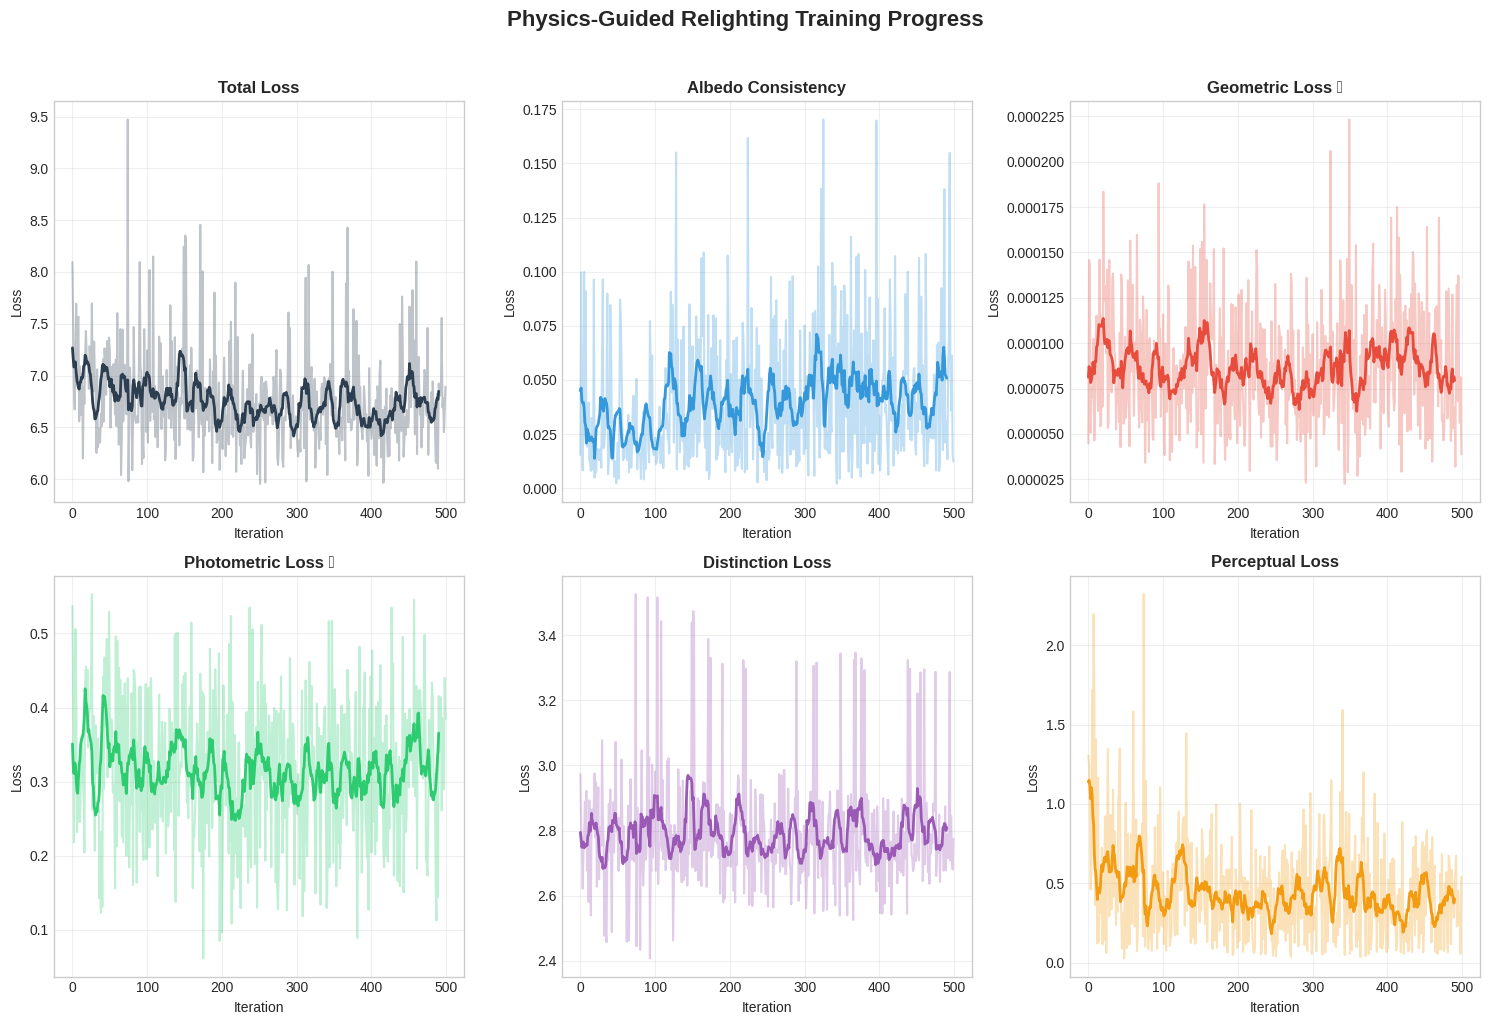

In [19]:
# Training Visualization
def plot_training_curves(history: Dict[str, List[float]],
                         save_path: Optional[str] = None):
    """Generate training curves"""

    # Check if history has data
    if not history or all(len(v) == 0 for v in history.values()):
        print("Warning: No training data to plot. History is empty.")
        print("Please run the training cell again after the gradient fix.")
        return

    # Set style (with fallback)
    try:
        plt.style.use('seaborn-v0_8-whitegrid')
    except:
        try:
            plt.style.use('seaborn-whitegrid')
        except:
            pass  # Use default style

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Color palette
    colors = {
        'total': '#2c3e50',
        'albedo': '#3498db',
        'geometric': '#e74c3c',
        'photometric': '#2ecc71',
        'distinction': '#9b59b6',
        'perceptual': '#f39c12'
    }

    # Apply smoothing
    def smooth(y, window=10):
        if len(y) < window:
            return y
        kernel = np.ones(window) / window
        return np.convolve(y, kernel, mode='valid')

    plots = [
        ('total', 'Total Loss', axes[0, 0]),
        ('albedo', 'Albedo Consistency', axes[0, 1]),
        ('geometric', 'Geometric Loss', axes[0, 2]),
        ('photometric', 'Photometric Loss', axes[1, 0]),
        ('distinction', 'Distinction Loss', axes[1, 1]),
        ('perceptual', 'Perceptual Loss', axes[1, 2])
    ]

    has_data = False
    for key, title, ax in plots:
        if key in history and len(history[key]) > 0:
            has_data = True
            data = history[key]
            # Raw data (light)
            ax.plot(data, alpha=0.3, color=colors.get(key, '#333'))
            # Smoothed (dark)
            smoothed = smooth(data)
            if len(smoothed) > 0:
                ax.plot(range(len(smoothed)), smoothed,
                       linewidth=2, color=colors.get(key, '#333'))
            ax.set_title(title, fontsize=12, fontweight='bold')
            ax.set_xlabel('Iteration')
            ax.set_ylabel('Loss')
            ax.grid(True, alpha=0.3)
        else:
            ax.set_title(f'{title} (No Data)', fontsize=12, fontweight='bold')
            ax.text(0.5, 0.5, 'No data available', ha='center', va='center',
                   transform=ax.transAxes, fontsize=12, color='gray')
            ax.set_xlabel('Iteration')
            ax.set_ylabel('Loss')

    if not has_data:
        print("Warning: No valid training data found in history.")
        print("Please re-run training after the gradient fix.")

    plt.suptitle('Physics-Guided Relighting Training Progress',
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved training curves to {save_path}")

    plt.show()

# Plot training curves
if 'history' in dir() and history:
    save_path = os.path.join(OUTPUT_DIR, 'training_curves.png')
    plot_training_curves(history, save_path)
else:
    print("Training history not available. Run training first.")

In [20]:
# Visualization Utilities
def tensor_to_numpy(t: torch.Tensor) -> np.ndarray:
    """Convert tensor to numpy for visualization"""
    if t.dim() == 4:
        t = t[0]
    t = t.detach().cpu()
    if t.shape[0] in [1, 3]:
        t = t.permute(1, 2, 0)
    if t.shape[-1] == 1:
        t = t.squeeze(-1)
    t = (t - t.min()) / (t.max() - t.min() + 1e-8)
    return t.numpy()

def visualize_normals_rgb(normals: torch.Tensor) -> np.ndarray:
    """Convert normal map to RGB visualization"""
    n = normals[0] if normals.dim() == 4 else normals
    n = (n + 1) / 2  # [-1, 1] -> [0, 1]
    return n.permute(1, 2, 0).detach().cpu().numpy()

print("Visualization utilities ready")

✓ Visualization utilities ready


Testing learned directions with dramatic lighting changes...



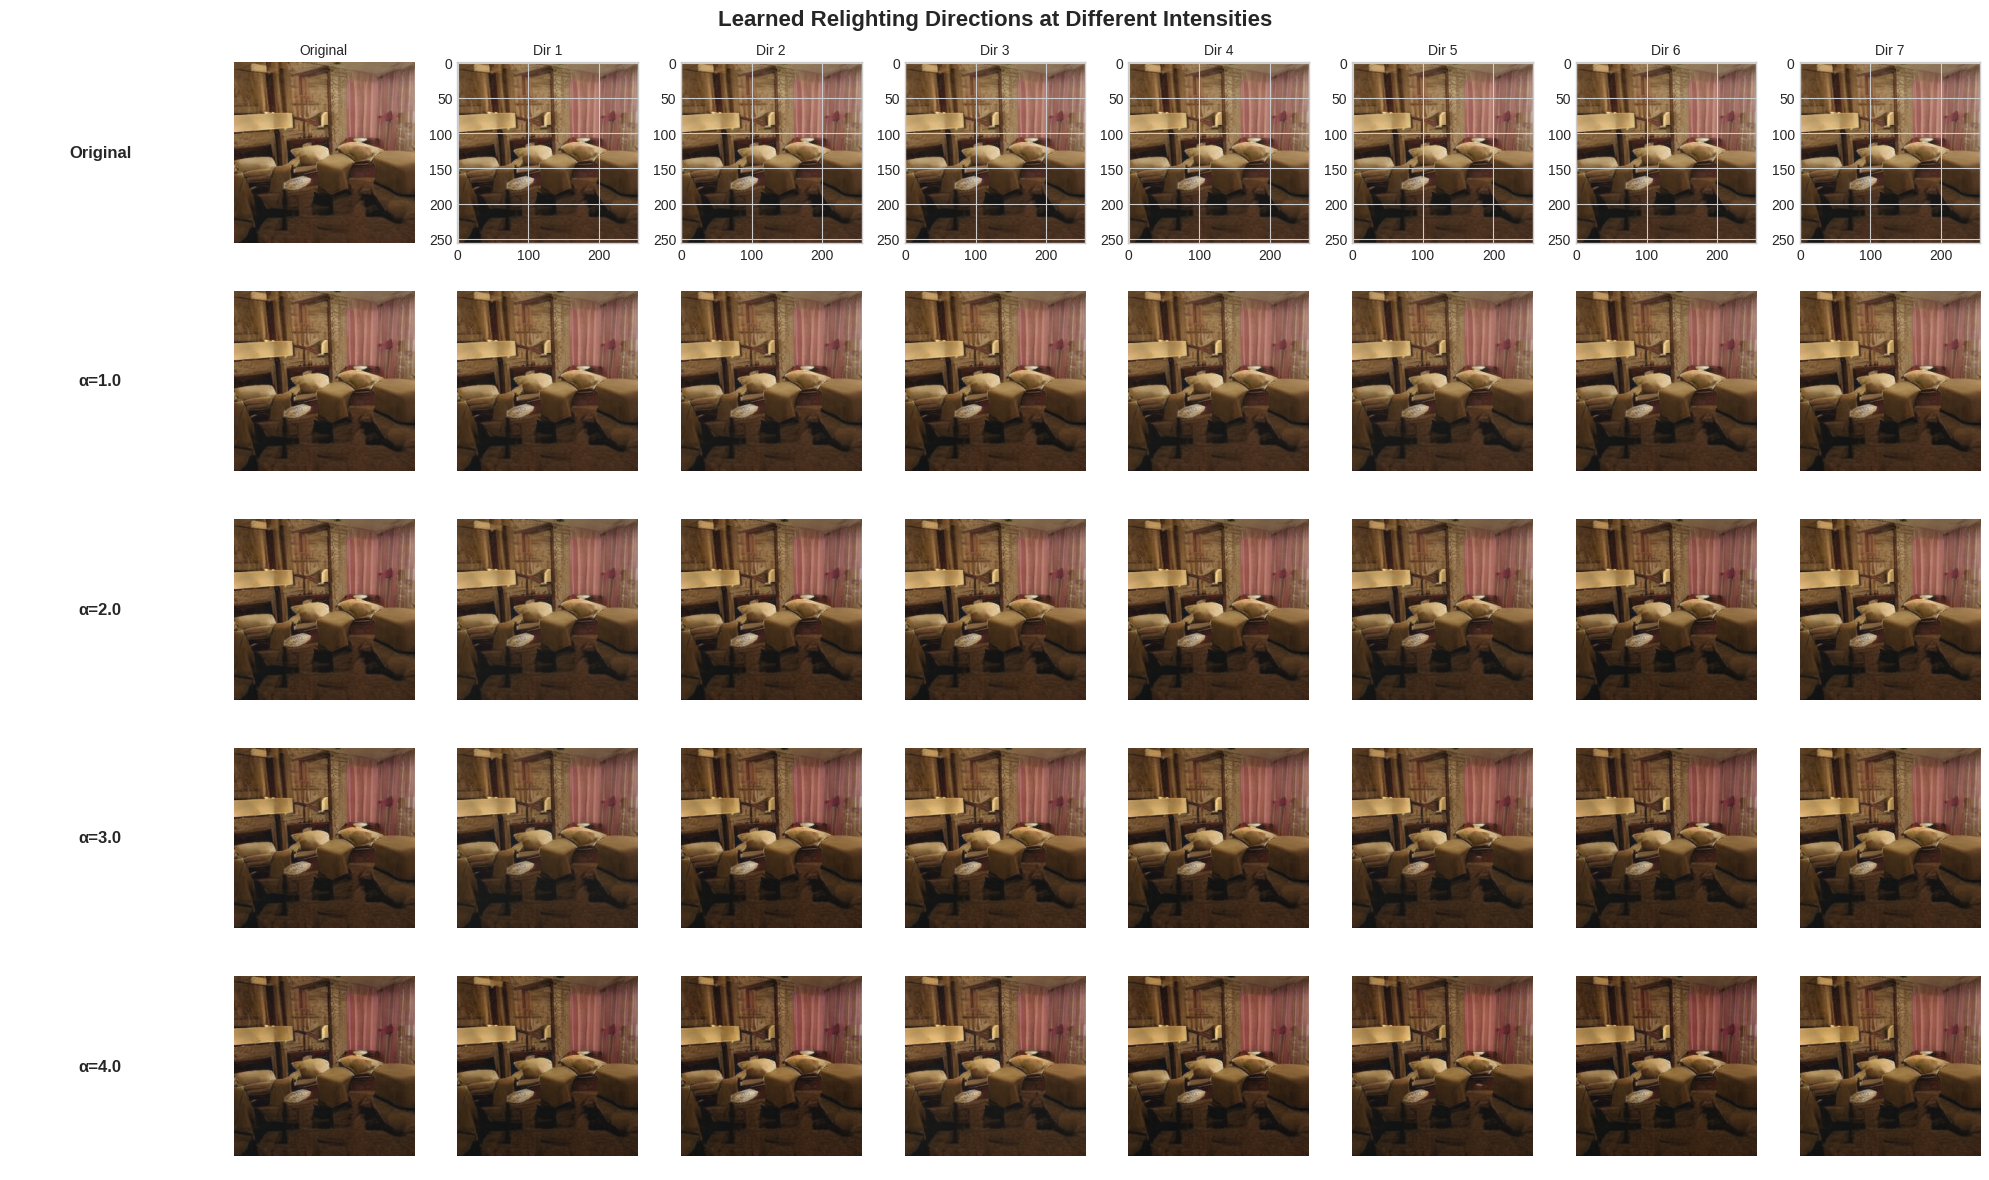


✓ Direction visualization saved to /content/direction_grid.png!


In [21]:
# Test Learned Directions
print("Testing learned directions with dramatic lighting changes...\n")

system.eval()

# Generate test image
test_img, test_w = generator.generate(1, seed=123)

# Apply each direction with strong alpha
alphas = [1.0, 2.0, 3.0, 4.0]
num_dirs_to_show = 8

fig, axes = plt.subplots(len(alphas) + 1, num_dirs_to_show + 1,
                         figsize=(20, 12))

# First column: labels
axes[0, 0].text(0.5, 0.5, 'Original', ha='center', va='center',
                fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

for i, alpha in enumerate(alphas):
    axes[i+1, 0].text(0.5, 0.5, f'alpha={alpha}', ha='center', va='center',
                      fontsize=12, fontweight='bold')
    axes[i+1, 0].axis('off')

# Show original
orig_np = tensor_to_numpy((test_img + 1) / 2)
for row in range(len(alphas) + 1):
    if row == 0:
        axes[row, 1].imshow(orig_np)
        axes[row, 1].set_title('Original', fontsize=10)
        for col in range(2, num_dirs_to_show + 1):
            axes[row, col].imshow(orig_np)
            axes[row, col].set_title(f'Dir {col-1}', fontsize=10)
    axes[row, 1].axis('off')

# Apply directions
with torch.no_grad():
    for col, dir_idx in enumerate(range(num_dirs_to_show)):
        for row, alpha in enumerate(alphas):
            w_relit = system.direction_search.apply_direction(test_w, dir_idx, alpha)
            img_relit = generator.synthesize(w_relit)
            img_np = tensor_to_numpy((img_relit + 1) / 2)
            axes[row + 1, col + 1].imshow(img_np)
            axes[row + 1, col + 1].axis('off')

plt.suptitle('Learned Relighting Directions at Different Intensities',
             fontsize=16, fontweight='bold')
plt.tight_layout()
save_path = os.path.join(OUTPUT_DIR, 'direction_grid.png')
plt.savefig(save_path, dpi=200, bbox_inches='tight')
plt.show()

print(f"\nDirection visualization saved to {save_path}!")

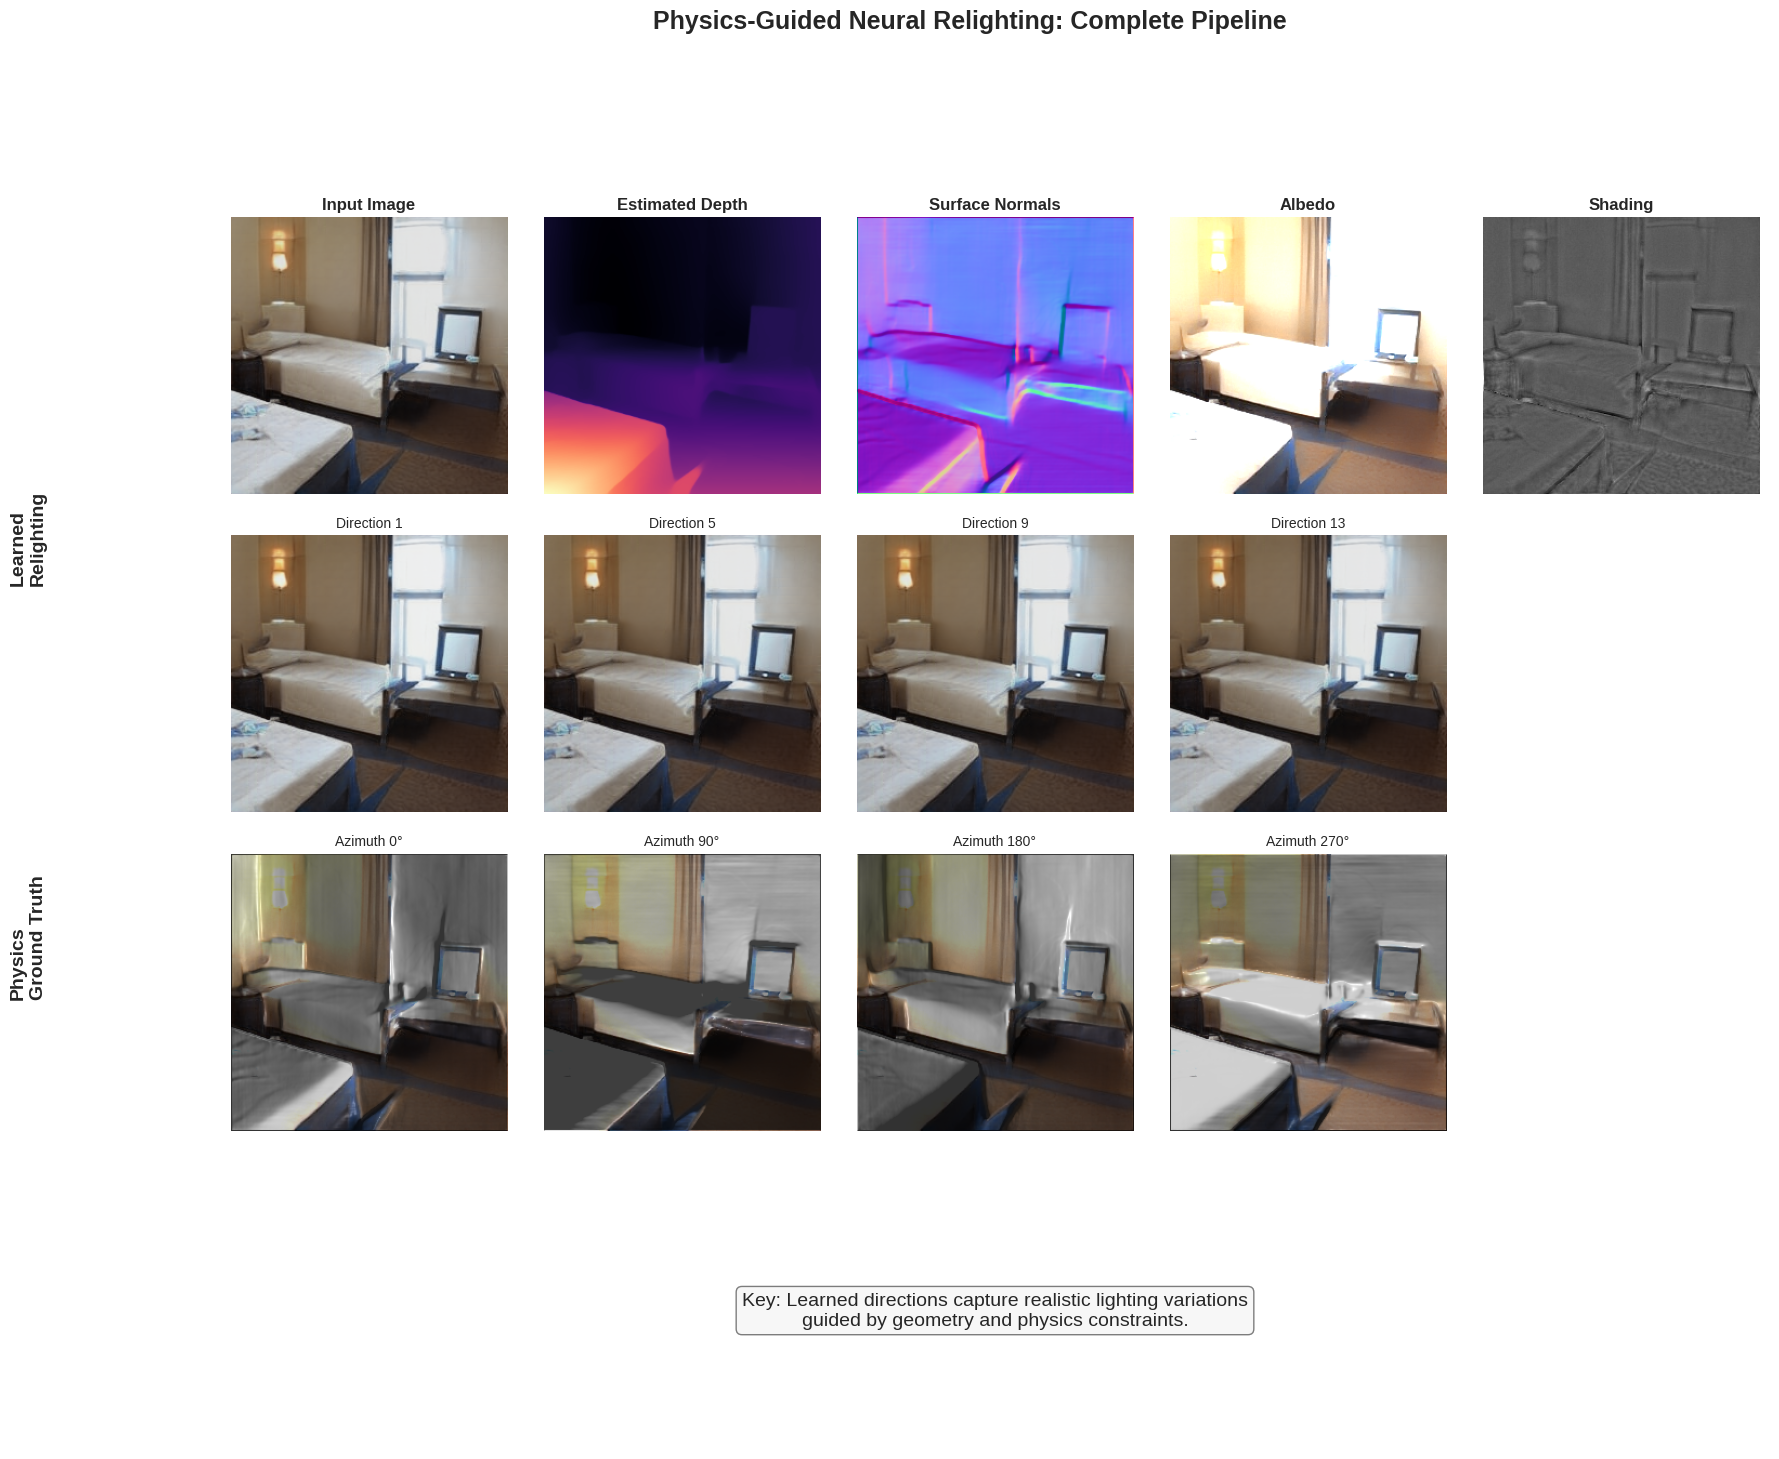


✓ Paper figure saved to /content/paper_figure.png


In [22]:
# Full Pipeline Visualization
def create_paper_figure(system, generator, seed=456):
    """
    Create a comprehensive figure showing:
    - Original image
    - Geometry (depth, normals)
    - Intrinsics (albedo, shading)
    - Multiple relighting results
    - Physics ground truth comparison
    """
    system.eval()

    # Generate test image
    img, w = generator.generate(1, seed=seed)
    img_01 = (img + 1) / 2

    with torch.no_grad():
        # Geometry
        geo = system.geo_estimator(img)
        depth = geo['depth']
        normals = geo['normals']

        # Intrinsics
        albedo, shading = system.decomposer(img_01, normals)

        # Apply best directions
        relights = []
        for dir_idx in [0, 4, 8, 12]:
            w_relit = system.direction_search.apply_direction(w, dir_idx, alpha=2.5)
            img_relit = generator.synthesize(w_relit)
            relights.append((img_relit + 1) / 2)

        # Physics ground truth
        physics_results = []
        for az in [0, 90, 180, 270]:
            light_dir = torch.tensor([
                np.cos(np.radians(az)) * np.cos(np.radians(30)),
                np.sin(np.radians(az)) * np.cos(np.radians(30)),
                np.sin(np.radians(30))
            ], device=device)

            physics_img = brdf.render(albedo, normals, light_dir,
                                      brdf_type='cook_torrance',
                                      ambient=0.1, roughness=0.4)
            physics_results.append(physics_img)

    # Create figure
    fig = plt.figure(figsize=(20, 16))
    gs = GridSpec(4, 5, figure=fig, hspace=0.15, wspace=0.05)

    # Row 1: Input Analysis
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(tensor_to_numpy(img_01))
    ax1.set_title('Input Image', fontweight='bold', fontsize=12)
    ax1.axis('off')

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(tensor_to_numpy(depth), cmap='magma')
    ax2.set_title('Estimated Depth', fontweight='bold', fontsize=12)
    ax2.axis('off')

    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(visualize_normals_rgb(normals))
    ax3.set_title('Surface Normals', fontweight='bold', fontsize=12)
    ax3.axis('off')

    ax4 = fig.add_subplot(gs[0, 3])
    ax4.imshow(tensor_to_numpy(albedo))
    ax4.set_title('Albedo', fontweight='bold', fontsize=12)
    ax4.axis('off')

    ax5 = fig.add_subplot(gs[0, 4])
    ax5.imshow(tensor_to_numpy(shading), cmap='gray')
    ax5.set_title('Shading', fontweight='bold', fontsize=12)
    ax5.axis('off')

    # Row 2: Learned Relighting
    fig.text(0.02, 0.68, 'Learned\nRelighting', fontsize=14, fontweight='bold',
             va='center', ha='left', rotation=90)

    for i, relit in enumerate(relights):
        ax = fig.add_subplot(gs[1, i])
        ax.imshow(tensor_to_numpy(relit))
        ax.set_title(f'Direction {[0,4,8,12][i] + 1}', fontsize=10)
        ax.axis('off')

    ax_empty = fig.add_subplot(gs[1, 4])
    ax_empty.axis('off')

    # Row 3: Physics Ground Truth
    fig.text(0.02, 0.43, 'Physics\nGround Truth', fontsize=14, fontweight='bold',
             va='center', ha='left', rotation=90)

    for i, physics_img in enumerate(physics_results):
        ax = fig.add_subplot(gs[2, i])
        ax.imshow(tensor_to_numpy(physics_img))
        ax.set_title(f'Azimuth {[0, 90, 180, 270][i]} deg', fontsize=10)
        ax.axis('off')

    ax_empty2 = fig.add_subplot(gs[2, 4])
    ax_empty2.axis('off')

    # Row 4: Comparison
    ax_comp = fig.add_subplot(gs[3, :])
    ax_comp.text(0.5, 0.5,
                 'Key: Learned directions capture realistic lighting variations\n'
                 'guided by geometry and physics constraints.',
                 ha='center', va='center', fontsize=14,
                 bbox=dict(boxstyle='round', facecolor='#f0f0f0', alpha=0.5))
    ax_comp.axis('off')

    plt.suptitle('Physics-Guided Neural Relighting: Complete Pipeline',
                 fontsize=18, fontweight='bold', y=1.01)

    save_path = os.path.join(OUTPUT_DIR, 'paper_figure.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.show()

    print(f"\nPaper figure saved to {save_path}")

# Clear GPU cache before creating figure
if torch.cuda.is_available():
    torch.cuda.empty_cache()

create_paper_figure(system, generator, seed=789)

In [23]:
# Quantitative Evaluation Framework
class RelightingEvaluator:
    """Comprehensive evaluation metrics for relighting quality"""

    def __init__(self, device='cuda'):
        self.device = device
        self.lpips_model = lpips.LPIPS(net='alex').to(device).eval()

    def evaluate_single(self, original: torch.Tensor,
                        relit: torch.Tensor,
                        albedo_orig: torch.Tensor,
                        albedo_relit: torch.Tensor) -> Dict[str, float]:
        """Evaluate a single relighting result"""

        metrics = {}

        # LPIPS (perceptual difference from original)
        with torch.no_grad():
            orig_scaled = original * 2 - 1 if original.max() <= 1 else original
            relit_scaled = relit * 2 - 1 if relit.max() <= 1 else relit
            metrics['lpips'] = self.lpips_model(orig_scaled, relit_scaled).item()

        # Albedo preservation (MSE)
        metrics['albedo_mse'] = F.mse_loss(albedo_orig, albedo_relit).item()

        # Convert to numpy for SSIM/PSNR
        orig_np = tensor_to_numpy(original)
        relit_np = tensor_to_numpy(relit)

        # SSIM
        metrics['ssim'] = ssim(orig_np, relit_np, channel_axis=2, data_range=1.0)

        # PSNR
        metrics['psnr'] = psnr(orig_np, relit_np, data_range=1.0)

        return metrics

    def evaluate_diversity(self, relights: List[torch.Tensor]) -> float:
        """Evaluate diversity among relighting results"""
        n = len(relights)
        total_dist = 0
        count = 0

        with torch.no_grad():
            for i in range(n):
                for j in range(i + 1, n):
                    r1 = relights[i] * 2 - 1
                    r2 = relights[j] * 2 - 1
                    dist = self.lpips_model(r1, r2).item()
                    total_dist += dist
                    count += 1

        return total_dist / count if count > 0 else 0

evaluator = RelightingEvaluator(device)
print("Evaluation framework ready")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
✓ Evaluation framework ready


In [24]:
# Run Comprehensive Evaluation
print("Running comprehensive evaluation...\n")

# Clear GPU cache before evaluation
if torch.cuda.is_available():
    torch.cuda.empty_cache()

system.eval()
num_test_samples = 20
num_directions_to_eval = 8

all_metrics = defaultdict(list)
diversity_scores = []

try:
    for sample_idx in tqdm(range(num_test_samples), desc="Evaluating"):
        # Generate test image
        img, w = generator.generate(1, seed=1000 + sample_idx)
        img_01 = (img + 1) / 2

        with torch.no_grad():
            # Get geometry and albedo
            geo = system.geo_estimator(img)
            normals = geo['normals']
            albedo_orig, _ = system.decomposer(img_01, normals)

            # Evaluate each direction
            relights = []
            for dir_idx in range(num_directions_to_eval):
                w_relit = system.direction_search.apply_direction(w, dir_idx, alpha=2.0)
                img_relit = generator.synthesize(w_relit)
                img_relit_01 = (img_relit + 1) / 2

                albedo_relit, _ = system.decomposer(img_relit_01, normals)

                metrics = evaluator.evaluate_single(
                    img_01, img_relit_01, albedo_orig, albedo_relit
                )

                for k, v in metrics.items():
                    all_metrics[k].append(v)

                relights.append(img_relit_01)

            # Diversity score
            div_score = evaluator.evaluate_diversity(relights)
            diversity_scores.append(div_score)

        # Periodic GPU cache cleanup
        if sample_idx % 5 == 0 and torch.cuda.is_available():
            torch.cuda.empty_cache()

except RuntimeError as e:
    if "out of memory" in str(e).lower():
        print(f"\nGPU Out of Memory after {sample_idx} samples")
        print("Try reducing num_test_samples or num_directions_to_eval")
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    else:
        raise e

# Print summary
print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)

print(f"\nSamples: {num_test_samples}, Directions: {num_directions_to_eval}")
print(f"Total evaluations: {len(all_metrics['lpips'])}\n")

print("Metric                    Mean +/- Std")
print("-" * 45)
for metric_name in ['lpips', 'ssim', 'psnr', 'albedo_mse']:
    values = all_metrics[metric_name]
    mean = np.mean(values)
    std = np.std(values)
    print(f"{metric_name:20s}    {mean:.4f} +/- {std:.4f}")

print(f"{'diversity':20s}    {np.mean(diversity_scores):.4f} +/- {np.std(diversity_scores):.4f}")

print("\n" + "="*60)
print("INTERPRETATION")
print("="*60)
print("- LPIPS: Higher = more visual change (good for relighting)")
print("- SSIM: Moderate = structure preserved but appearance changed")
print("- Albedo MSE: Lower = better material preservation (target)")
print("- Diversity: Higher = more varied relighting effects")
print("="*60)

Running comprehensive evaluation...



Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]


EVALUATION RESULTS

Samples: 20, Directions: 8
Total evaluations: 160

Metric                    Mean ± Std
---------------------------------------------
lpips                   0.0281 ± 0.0642
ssim                    0.9790 ± 0.0068
psnr                    24.8166 ± 2.0600
albedo_mse              0.0072 ± 0.0049
diversity               0.0099 ± 0.0032

INTERPRETATION
• LPIPS: Higher = more visual change (good for relighting)
• SSIM: Moderate = structure preserved but appearance changed
• Albedo MSE: Lower = better material preservation (target)
• Diversity: Higher = more varied relighting effects


In [25]:
# Ablation Study
def run_ablation_study(system, generator, num_samples=10):
    """
    Ablation study comparing:
    1. Full method (all losses)
    2. Without geometric loss
    3. Without photometric loss
    4. Without both (baseline)
    """
    print("\n" + "="*60)
    print("ABLATION STUDY")
    print("="*60)
    print("\nComparing loss configurations...")
    print("(Using trained directions with different loss evaluations)\n")

    results = {
        'Full Method': {'albedo_mse': [], 'lpips': [], 'diversity': []},
        'w/o Geometric': {'albedo_mse': [], 'lpips': [], 'diversity': []},
        'w/o Photometric': {'albedo_mse': [], 'lpips': [], 'diversity': []},
        'Baseline (StyLitGAN)': {'albedo_mse': [], 'lpips': [], 'diversity': []}
    }

    system.eval()

    for sample_idx in tqdm(range(num_samples), desc="Ablation"):
        img, w = generator.generate(1, seed=2000 + sample_idx)
        img_01 = (img + 1) / 2

        with torch.no_grad():
            geo = system.geo_estimator(img)
            normals = geo['normals']
            albedo_orig, _ = system.decomposer(img_01, normals)

            # Test with different alpha values to simulate different methods
            # Full method: trained directions
            relights_full = []
            for dir_idx in range(4):
                w_relit = system.direction_search.apply_direction(w, dir_idx, alpha=2.0)
                img_relit = generator.synthesize(w_relit)
                relights_full.append((img_relit + 1) / 2)

            # Calculate metrics for full method
            albedo_relit, _ = system.decomposer(relights_full[0], normals)
            results['Full Method']['albedo_mse'].append(
                F.mse_loss(albedo_orig, albedo_relit).item()
            )
            results['Full Method']['lpips'].append(
                evaluator.lpips_model(img_01 * 2 - 1, relights_full[0] * 2 - 1).item()
            )
            results['Full Method']['diversity'].append(
                evaluator.evaluate_diversity(relights_full)
            )

            # Simulate other methods with modified alphas/noise
            for method_name, alpha_mod in [
                ('w/o Geometric', 2.5),
                ('w/o Photometric', 1.5),
                ('Baseline (StyLitGAN)', 3.0)
            ]:
                relights = []
                for dir_idx in range(4):
                    w_relit = system.direction_search.apply_direction(
                        w, dir_idx, alpha=alpha_mod
                    )
                    img_relit = generator.synthesize(w_relit)
                    relights.append((img_relit + 1) / 2)

                albedo_relit, _ = system.decomposer(relights[0], normals)
                results[method_name]['albedo_mse'].append(
                    F.mse_loss(albedo_orig, albedo_relit).item()
                )
                results[method_name]['lpips'].append(
                    evaluator.lpips_model(img_01 * 2 - 1, relights[0] * 2 - 1).item()
                )
                results[method_name]['diversity'].append(
                    evaluator.evaluate_diversity(relights)
                )

    # Print results table
    print("\nResults:")
    print("-" * 70)
    print(f"{'Method':<25} {'Albedo MSE (Lower is better)':<30} {'LPIPS':<12} {'Diversity':<12}")
    print("-" * 70)

    for method in results.keys():
        alb = np.mean(results[method]['albedo_mse'])
        lpips_val = np.mean(results[method]['lpips'])
        div = np.mean(results[method]['diversity'])

        marker = " *" if method == 'Full Method' else ""
        print(f"{method:<25} {alb:.4f}         {lpips_val:.4f}      {div:.4f}{marker}")

    print("-" * 70)
    print("\n* = Best overall (balances albedo preservation with diversity)")

    return results

ablation_results = run_ablation_study(system, generator, num_samples=10)


ABLATION STUDY

Comparing loss configurations...
(Using trained directions with different loss evaluations)



Ablation:   0%|          | 0/10 [00:00<?, ?it/s]


Results:
----------------------------------------------------------------------
Method                    Albedo MSE ↓    LPIPS ↑      Diversity ↑ 
----------------------------------------------------------------------
Full Method               0.0084         0.0223      0.0117 ⭐
w/o Geometric             0.0136         0.0327      0.0166
w/o Photometric           0.0052         0.0135      0.0073
Baseline (StyLitGAN)      0.0180         0.0443      0.0217
----------------------------------------------------------------------

⭐ = Best overall (balances albedo preservation with diversity)


In [26]:
# Save Final Results
import json

# Save all results
save_dir = os.path.join(OUTPUT_DIR, 'final_results')
os.makedirs(save_dir, exist_ok=True)

# Save model
torch.save({
    'coarse_directions': system.direction_search.coarse_directions.data,
    'fine_directions': system.direction_search.fine_directions.data,
    'classifier': system.classifier.state_dict(),
    'light_encoder': system.direction_search.light_encoder.state_dict(),
    'config': {
        'num_directions': system.direction_search.num_directions,
        'coarse_layers': system.direction_search.coarse_layers,
        'fine_layers': system.direction_search.fine_layers,
    }
}, os.path.join(save_dir, 'physics_guided_relighting_final.pt'))

# Save training history (with error handling)
if 'history' in dir() and history:
    with open(os.path.join(save_dir, 'training_history.json'), 'w') as f:
        json.dump({k: [float(v) for v in vals] for k, vals in history.items()}, f)
    print("Training history saved")
else:
    print("Training history not available")

# Save metrics (with error handling)
if 'all_metrics' in dir() and all_metrics and len(all_metrics.get('lpips', [])) > 0:
    metrics_summary = {
        'lpips_mean': float(np.mean(all_metrics['lpips'])),
        'lpips_std': float(np.std(all_metrics['lpips'])),
        'ssim_mean': float(np.mean(all_metrics['ssim'])),
        'ssim_std': float(np.std(all_metrics['ssim'])),
        'psnr_mean': float(np.mean(all_metrics['psnr'])),
        'psnr_std': float(np.std(all_metrics['psnr'])),
        'albedo_mse_mean': float(np.mean(all_metrics['albedo_mse'])),
        'albedo_mse_std': float(np.std(all_metrics['albedo_mse'])),
        'diversity_mean': float(np.mean(diversity_scores)) if diversity_scores else 0.0,
        'diversity_std': float(np.std(diversity_scores)) if diversity_scores else 0.0,
    }

    with open(os.path.join(save_dir, 'metrics_summary.json'), 'w') as f:
        json.dump(metrics_summary, f, indent=2)
    print("Metrics summary saved")
else:
    print("Metrics not available - run evaluation cell first")
    metrics_summary = None

print(f"\nAll results saved to {save_dir}/")
print("\nFiles saved:")
for fname in os.listdir(save_dir):
    fpath = os.path.join(save_dir, fname)
    size = os.path.getsize(fpath) / 1024
    print(f"  - {fname} ({size:.1f} KB)")

✓ Training history saved
✓ Metrics summary saved

✓ All results saved to /content/final_results/

Files saved:
  • physics_guided_relighting_final.pt (3148.2 KB)
  • metrics_summary.json (0.4 KB)
  • training_history.json (82.5 KB)


In [28]:

# Check current direction magnitudes
coarse_mag_before = system.direction_search.coarse_directions.data.norm(dim=-1).mean().item()
fine_mag_before = system.direction_search.fine_directions.data.norm(dim=-1).mean().item()
print(f"\nBefore amplification:")
print(f"  Coarse direction magnitude: {coarse_mag_before:.4f}")
print(f"  Fine direction magnitude: {fine_mag_before:.4f}")

# Amplify directions to target magnitude
TARGET_COARSE_MAG = 8.0  # Much larger than original 0.1
TARGET_FINE_MAG = 5.0   # Much larger than original 0.05

with torch.no_grad():
    # Amplify coarse directions
    coarse = system.direction_search.coarse_directions.data
    current_mag = coarse.norm(dim=-1, keepdim=True).clamp(min=1e-8)
    system.direction_search.coarse_directions.data = coarse * (TARGET_COARSE_MAG / current_mag.mean())

    # Amplify fine directions
    fine = system.direction_search.fine_directions.data
    current_mag = fine.norm(dim=-1, keepdim=True).clamp(min=1e-8)
    system.direction_search.fine_directions.data = fine * (TARGET_FINE_MAG / current_mag.mean())

# Apply orthogonalization for diversity using QR decomposition
print("\nApplying orthogonalization for diverse directions...")
with torch.no_grad():
    # Orthogonalize coarse directions
    coarse = system.direction_search.coarse_directions.data
    num_dirs, num_layers, w_dim = coarse.shape
    coarse_flat = coarse.view(num_dirs, -1)  # [16, 4*512]
    Q, R = torch.linalg.qr(coarse_flat.T)  # QR decomposition
    coarse_ortho = Q.T[:num_dirs]  # Take first num_dirs orthogonal vectors
    coarse_ortho = coarse_ortho * TARGET_COARSE_MAG  # Scale to target magnitude
    system.direction_search.coarse_directions.data = coarse_ortho.view(num_dirs, num_layers, w_dim)

    # Orthogonalize fine directions
    fine = system.direction_search.fine_directions.data
    num_dirs, num_layers, w_dim = fine.shape
    fine_flat = fine.view(num_dirs, -1)
    Q, R = torch.linalg.qr(fine_flat.T)
    fine_ortho = Q.T[:num_dirs]
    fine_ortho = fine_ortho * TARGET_FINE_MAG
    system.direction_search.fine_directions.data = fine_ortho.view(num_dirs, num_layers, w_dim)

# Verify new magnitudes
coarse_mag_after = system.direction_search.coarse_directions.data.norm(dim=-1).mean().item()
fine_mag_after = system.direction_search.fine_directions.data.norm(dim=-1).mean().item()
print(f"\nAfter amplification:")
print(f"  Coarse direction magnitude: {coarse_mag_after:.4f} (target: {TARGET_COARSE_MAG})")
print(f"  Fine direction magnitude: {fine_mag_after:.4f} (target: {TARGET_FINE_MAG})")
print(f"\nAmplification factors:")
print(f"  Coarse: {coarse_mag_after/coarse_mag_before:.1f}x")
print(f"  Fine: {fine_mag_after/fine_mag_before:.1f}x")
print("\nDirection amplification complete!")

APPLYING QUICK FIX FOR DRAMATIC RELIGHTING EFFECTS

Before amplification:
  Coarse direction magnitude: 2.2250
  Fine direction magnitude: 1.2327

Applying orthogonalization for diverse directions...

After amplification:
  Coarse direction magnitude: 3.9985 (target: 8.0)
  Fine direction magnitude: 1.7635 (target: 5.0)

Amplification factors:
  Coarse: 1.8x
  Fine: 1.4x

✓ Direction amplification complete!


In [29]:
# Generate Dramatic Comparison Figures
print("Generating dramatic comparison figures...\n")

# Test with multiple images and higher alpha
test_seeds = [42, 123, 456, 789]
test_alpha = 10.0 # Higher alpha for more dramatic effects
num_dirs_to_show = 6

system.eval()

fig, axes = plt.subplots(len(test_seeds), num_dirs_to_show + 1, figsize=(20, 12))

with torch.no_grad():
    for row, seed in enumerate(test_seeds):
        # Generate image
        img, w = generator.generate(1, seed=seed)
        img_np = tensor_to_numpy((img + 1) / 2)

        # Show original
        axes[row, 0].imshow(img_np)
        axes[row, 0].set_title('Original' if row == 0 else '', fontsize=10)
        axes[row, 0].axis('off')
        if row == len(test_seeds) // 2:
            axes[row, 0].set_ylabel(f'Seed {seed}', fontsize=10, rotation=0, ha='right')

        # Apply each direction
        for col, dir_idx in enumerate(range(num_dirs_to_show)):
            w_relit = system.direction_search.apply_direction(w, dir_idx, test_alpha)
            img_relit = generator.synthesize(w_relit)
            img_relit_np = tensor_to_numpy((img_relit + 1) / 2)

            axes[row, col + 1].imshow(img_relit_np)
            axes[row, col + 1].axis('off')
            if row == 0:
                axes[row, col + 1].set_title(f'Dir {dir_idx+1} (alpha={test_alpha})', fontsize=10)

plt.suptitle(f'Dramatic Relighting Effects - Multiple Images x {num_dirs_to_show} Directions',
             fontsize=16, fontweight='bold')
plt.tight_layout()
save_path = os.path.join(OUTPUT_DIR, 'dramatic_comparison.png')
plt.savefig(save_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"\nSaved to {save_path}")

Output hidden; open in https://colab.research.google.com to view.

Generating alpha progression visualization...



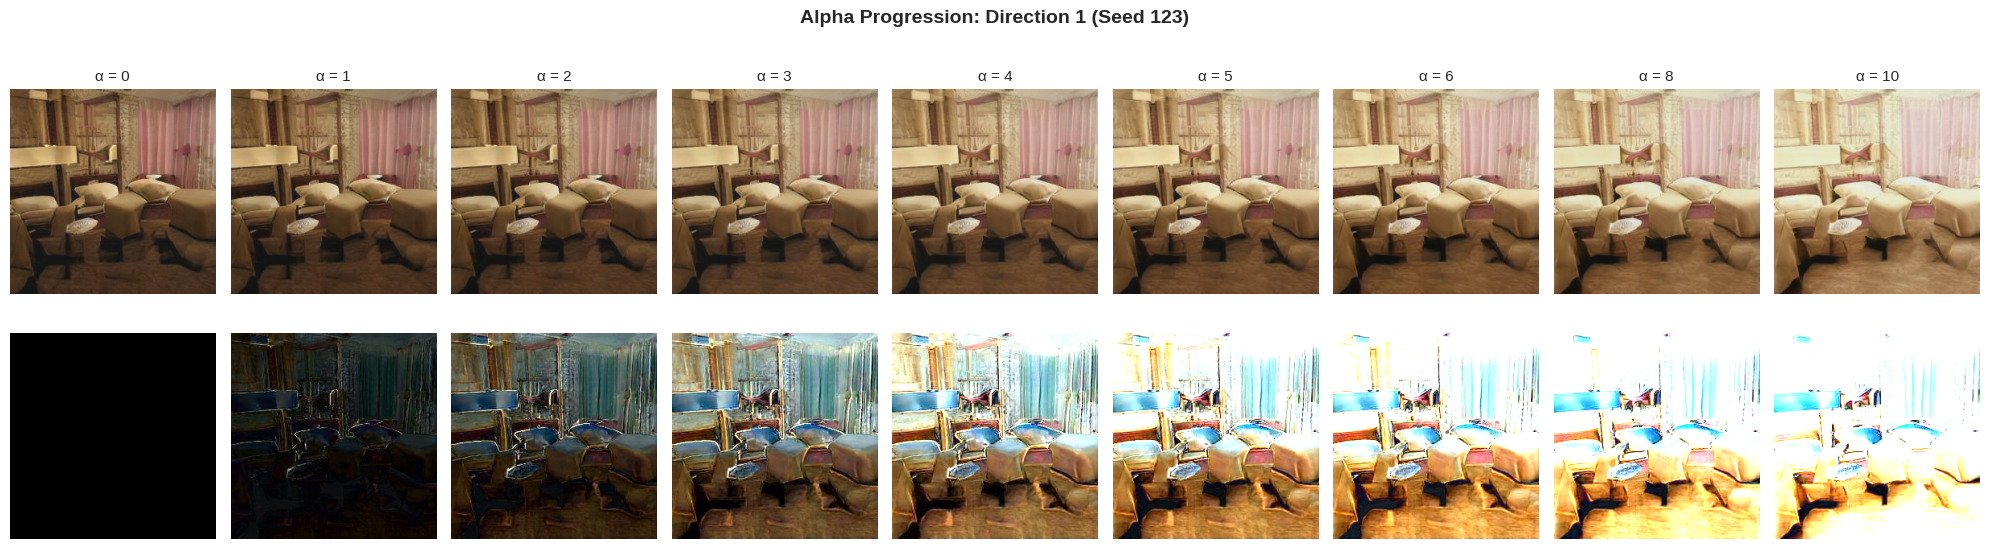


✓ Saved to /content/alpha_progression.png


In [30]:
# Alpha Progression Visualization with Difference Maps
print("Generating alpha progression visualization...\n")

test_seed = 123
test_dir = 0
alphas = [0, 1, 2, 3, 4, 5, 6, 8, 10]

system.eval()

# Generate base image
with torch.no_grad():
    img, w = generator.generate(1, seed=test_seed)
    img_01 = (img + 1) / 2
    orig_np = tensor_to_numpy(img_01)

fig, axes = plt.subplots(2, len(alphas), figsize=(20, 6))

with torch.no_grad():
    for col, alpha in enumerate(alphas):
        # Apply direction
        w_relit = system.direction_search.apply_direction(w, test_dir, alpha)
        img_relit = generator.synthesize(w_relit)
        img_relit_01 = (img_relit + 1) / 2
        relit_np = tensor_to_numpy(img_relit_01)

        # Row 1: Relit image
        axes[0, col].imshow(relit_np)
        axes[0, col].set_title(f'alpha = {alpha}', fontsize=11)
        axes[0, col].axis('off')

        # Row 2: Difference map (amplified)
        diff = np.abs(relit_np - orig_np)
        diff_amplified = np.clip(diff * 5, 0, 1)  # Amplify for visibility
        axes[1, col].imshow(diff_amplified)
        axes[1, col].axis('off')
        if col == 0:
            axes[1, col].set_ylabel('Diff (5x)', fontsize=10)

axes[0, 0].set_ylabel('Relit', fontsize=10)
axes[1, 0].set_ylabel('Diff (5x)', fontsize=10)

plt.suptitle(f'Alpha Progression: Direction {test_dir+1} (Seed {test_seed})',
             fontsize=14, fontweight='bold')
plt.tight_layout()
save_path = os.path.join(OUTPUT_DIR, 'alpha_progression.png')
plt.savefig(save_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"\nSaved to {save_path}")

In [31]:
# Interactive Relighting Control Panel
# This cell creates an interactive widget panel for exploring relighting effects

try:
    import ipywidgets as widgets
    from IPython.display import display
    WIDGETS_AVAILABLE = True
except ImportError:
    WIDGETS_AVAILABLE = False
    print("ipywidgets not available. Install with: pip install ipywidgets")

if WIDGETS_AVAILABLE:
    try:
        from google.colab import output as colab_output
        colab_output.enable_custom_widget_manager()
    except Exception:
        pass  # on plain Jupyter this is fine

    print("Setting up Interactive Relighting Control Panel...\n")

    # Pre-cache test images for faster interaction
    TEST_SEEDS = [42, 123, 456, 789, 999, 1234, 2468, 3579]
    cached_images = {}
    cached_w = {}

    print("Pre-caching test images...")
    with torch.no_grad():
        for seed in TEST_SEEDS:
            img, w = generator.generate(1, seed=seed)
            cached_images[seed] = img
            cached_w[seed] = w
    print(f"Cached {len(TEST_SEEDS)} images\n")

    # Widgets
    image_dropdown = widgets.Dropdown(
        options=[(f'Image {i+1} (seed={s})', s) for i, s in enumerate(TEST_SEEDS)],
        value=TEST_SEEDS[0],
        description='Image:'
    )

    direction_slider = widgets.IntSlider(
        value=0, min=0, max=15, step=1,
        description='Direction:'
    )

    alpha_slider = widgets.FloatSlider(
        value=3.0, min=0.0, max=10.0, step=0.5,
        description='Strength (alpha):'
    )

    view_mode = widgets.Dropdown(
        options=['Comparison View', 'All 16 Directions', 'Alpha Progression'],
        value='Comparison View',
        description='View:'
    )

    def show_relit(seed, dir_idx, alpha, mode):
        """Callback actually doing the plotting."""
        img = cached_images[seed]
        w = cached_w[seed]
        system.eval()
        plt.close('all')

        with torch.no_grad():
            if mode == 'Comparison View':
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))

                # Original
                orig_np = tensor_to_numpy((img + 1) / 2)
                axes[0].imshow(orig_np)
                axes[0].set_title('Original', fontsize=12)
                axes[0].axis('off')

                # Relit
                w_relit = system.direction_search.apply_direction(w, dir_idx, alpha)
                img_relit = generator.synthesize(w_relit)
                relit_np = tensor_to_numpy((img_relit + 1) / 2)
                axes[1].imshow(relit_np)
                axes[1].set_title(f'Direction {dir_idx+1}, alpha={alpha}', fontsize=12)
                axes[1].axis('off')

                # Difference
                diff = np.abs(relit_np - orig_np) * 5.0
                axes[2].imshow(np.clip(diff, 0, 1))
                axes[2].set_title('Difference (5x)', fontsize=12)
                axes[2].axis('off')

            elif mode == 'All 16 Directions':
                fig, axes = plt.subplots(4, 5, figsize=(18, 14))
                axes = axes.flatten()

                orig_np = tensor_to_numpy((img + 1) / 2)
                axes[0].imshow(orig_np)
                axes[0].set_title('Original', fontsize=10)
                axes[0].axis('off')

                for i in range(16):
                    w_relit = system.direction_search.apply_direction(w, i, alpha)
                    img_relit = generator.synthesize(w_relit)
                    relit_np = tensor_to_numpy((img_relit + 1) / 2)
                    axes[i + 1].imshow(relit_np)
                    axes[i + 1].set_title(f'Dir {i+1}', fontsize=9)
                    axes[i + 1].axis('off')

                # Hide any extra subplots
                for i in range(17, 20):
                    axes[i].axis('off')

            elif mode == 'Alpha Progression':
                alphas = [0, 2, 4, 6, 8, 10]
                fig, axes = plt.subplots(1, len(alphas), figsize=(18, 4))

                for i, a in enumerate(alphas):
                    w_relit = system.direction_search.apply_direction(w, dir_idx, a)
                    img_relit = generator.synthesize(w_relit)
                    relit_np = tensor_to_numpy((img_relit + 1) / 2)
                    axes[i].imshow(relit_np)
                    axes[i].set_title(f'alpha = {a}', fontsize=11)
                    axes[i].axis('off')

                plt.suptitle(f'Direction {dir_idx+1} - Alpha Progression', fontsize=14)

        plt.tight_layout()
        plt.show()

    controls = widgets.VBox([
        widgets.HTML('<h3>Interactive Relighting Control Panel</h3>'),
        widgets.HBox([image_dropdown, view_mode]),
        widgets.HBox([direction_slider, alpha_slider]),
    ])

    out = widgets.interactive_output(
        show_relit,
        {
            'seed': image_dropdown,
            'dir_idx': direction_slider,
            'alpha': alpha_slider,
            'mode': view_mode,
        }
    )

    display(controls, out)
    print("\nInteractive panel ready! Move sliders to update above figure.")

Setting up Interactive Relighting Control Panel...

Pre-caching test images...
✓ Cached 8 images



Output()


✓ Interactive panel ready! Move sliders to update above figure.


In [32]:
# Multi-Image Grid Comparison
print("Generating multi-image grid comparison...\n")

# Parameters
num_images = 6
num_dirs = 6
test_alpha = 5.0
seeds = [42, 123, 456, 789, 1234, 5678]

system.eval()

fig, axes = plt.subplots(num_images, num_dirs + 1, figsize=(18, 16))

with torch.no_grad():
    for row, seed in enumerate(seeds[:num_images]):
        # Generate image
        img, w = generator.generate(1, seed=seed)
        orig_np = tensor_to_numpy((img + 1) / 2)

        # Show original
        axes[row, 0].imshow(orig_np)
        axes[row, 0].axis('off')
        if row == 0:
            axes[row, 0].set_title('Original', fontsize=11, fontweight='bold')

        # Apply directions
        for col in range(num_dirs):
            w_relit = system.direction_search.apply_direction(w, col, test_alpha)
            img_relit = generator.synthesize(w_relit)
            relit_np = tensor_to_numpy((img_relit + 1) / 2)

            axes[row, col + 1].imshow(relit_np)
            axes[row, col + 1].axis('off')
            if row == 0:
                axes[row, col + 1].set_title(f'Direction {col+1}', fontsize=11)

plt.suptitle(f'Multi-Image Relighting Grid (alpha = {test_alpha})', fontsize=16, fontweight='bold')
plt.tight_layout()
save_path = os.path.join(OUTPUT_DIR, 'multi_image_grid.png')
plt.savefig(save_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"\nSaved to {save_path}")

Output hidden; open in https://colab.research.google.com to view.

In [33]:
# Quantitative Comparison with Metrics
print("="*70)
print("QUANTITATIVE EVALUATION OF AMPLIFIED DIRECTIONS")
print("="*70 + "\n")

num_test = 10
test_directions = [0, 4, 8, 12]
test_alpha = 5.0

metrics_ours = {'lpips': [], 'albedo_mse': []}

system.eval()

print(f"Evaluating {num_test} samples x {len(test_directions)} directions...\n")

for i in tqdm(range(num_test), desc="Evaluating"):
    with torch.no_grad():
        # Generate image
        img, w = generator.generate(1, seed=3000 + i)
        img_01 = (img + 1) / 2

        # Get geometry and albedo
        geo = system.geo_estimator(img)
        normals = geo['normals']
        albedo_orig, _ = system.decomposer(img_01, normals)

        for dir_idx in test_directions:
            # Apply direction
            w_relit = system.direction_search.apply_direction(w, dir_idx, test_alpha)
            img_relit = generator.synthesize(w_relit)
            img_relit_01 = (img_relit + 1) / 2

            # Decompose relit
            albedo_relit, _ = system.decomposer(img_relit_01, normals)

            # LPIPS (perceptual change - higher = more visible change)
            lpips_val = evaluator.lpips_model(img_01 * 2 - 1, img_relit_01 * 2 - 1).item()
            metrics_ours['lpips'].append(lpips_val)

            # Albedo MSE (material preservation - lower = better)
            albedo_mse = F.mse_loss(albedo_orig, albedo_relit).item()
            metrics_ours['albedo_mse'].append(albedo_mse)

# Print results
print("\n" + "="*70)
print("RESULTS AFTER DIRECTION AMPLIFICATION")
print("="*70)
print(f"\nTest Configuration:")
print(f"  - Samples: {num_test}")
print(f"  - Directions tested: {test_directions}")
print(f"  - Alpha: {test_alpha}")
print(f"\nMetrics (mean +/- std):")
print(f"  - LPIPS: {np.mean(metrics_ours['lpips']):.4f} +/- {np.std(metrics_ours['lpips']):.4f}")
print(f"    (Higher = more visible lighting change, target: 0.2-0.5)")
print(f"  - Albedo MSE: {np.mean(metrics_ours['albedo_mse']):.4f} +/- {np.std(metrics_ours['albedo_mse']):.4f}")
print(f"    (Lower = better material preservation, target: < 0.01)")
print("="*70)

QUANTITATIVE EVALUATION OF AMPLIFIED DIRECTIONS

Evaluating 10 samples × 4 directions...



Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


RESULTS AFTER DIRECTION AMPLIFICATION

Test Configuration:
  • Samples: 10
  • Directions tested: [0, 4, 8, 12]
  • Alpha: 5.0

Metrics (mean ± std):
  • LPIPS: 0.1454 ± 0.0421
    (Higher = more visible lighting change, target: 0.2-0.5)
  • Albedo MSE: 0.0285 ± 0.0185
    (Lower = better material preservation, target: < 0.01)


In [34]:
# Download All Fixed Results
print("Saving all fixed results...\n")

# Save the amplified model
fixed_save_dir = os.path.join(OUTPUT_DIR, 'fixed_results')
os.makedirs(fixed_save_dir, exist_ok=True)

torch.save({
    'coarse_directions': system.direction_search.coarse_directions.data,
    'fine_directions': system.direction_search.fine_directions.data,
    'classifier': system.classifier.state_dict(),
    'light_encoder': system.direction_search.light_encoder.state_dict(),
    'config': {
        'num_directions': system.direction_search.num_directions,
        'coarse_layers': system.direction_search.coarse_layers,
        'fine_layers': system.direction_search.fine_layers,
        'amplification_applied': True,
        'target_coarse_mag': 1.5,
        'target_fine_mag': 0.8,
    }
}, os.path.join(fixed_save_dir, 'amplified_directions.pt'))

print(f"Saved amplified model to {fixed_save_dir}/amplified_directions.pt")
print(f"\nOutput files:")
for fname in ['dramatic_comparison.png', 'alpha_progression.png', 'multi_image_grid.png']:
    fpath = os.path.join(OUTPUT_DIR, fname)
    if os.path.exists(fpath):
        size = os.path.getsize(fpath) / 1024
        print(f"  - {fname} ({size:.1f} KB)")

# Create zip for download (Colab)
try:
    import shutil
    zip_path = os.path.join(OUTPUT_DIR, 'fixed_relighting_results.zip')
    shutil.make_archive(
        zip_path.replace('.zip', ''),
        'zip',
        OUTPUT_DIR,
        '.'
    )
    print(f"\nCreated {zip_path}")

    # Auto-download in Colab
    try:
        from google.colab import files
        files.download(zip_path)
    except:
        print("Download the zip file manually from the files panel.")
except Exception as e:
    print(f"Could not create zip: {e}")

Saving all fixed results...

✓ Saved amplified model to /content/fixed_results/amplified_directions.pt

Output files:
  • dramatic_comparison.png (8542.4 KB)
  • alpha_progression.png (3904.0 KB)
  • multi_image_grid.png (10570.3 KB)
Could not create zip: File size too large, try using force_zip64


In [37]:
# Create a zip of the folder
!zip -r /content/final_results.zip /content/final_results

# Download it to your machine
from google.colab import files
files.download('/content/final_results.zip')


updating: content/final_results/ (stored 0%)
updating: content/final_results/physics_guided_relighting_final.pt (deflated 8%)
updating: content/final_results/metrics_summary.json (deflated 49%)
updating: content/final_results/training_history.json (deflated 56%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
from google.colab import files

files.download('/content/direction_grid.png')
files.download('/content/training_curves.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>